# Assignment2 Realm of Deep Learning

## Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Datasets/

/content/drive/MyDrive/Datasets


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import random_split


# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 设置数据转换
transform = transforms.Compose([
    transforms.ToTensor(),  # 转换图片为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化
])

# 下载训练集和测试集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

In [5]:
from torch.utils.data import random_split

num_train = len(trainset)
num_val = int(0.2 * num_train)  # 使用20%的训练数据作为验证集
num_train -= num_val

train_data, val_data = random_split(trainset, [num_train, num_val])

trainloader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
valloader = DataLoader(val_data, batch_size=4, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# 类别标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

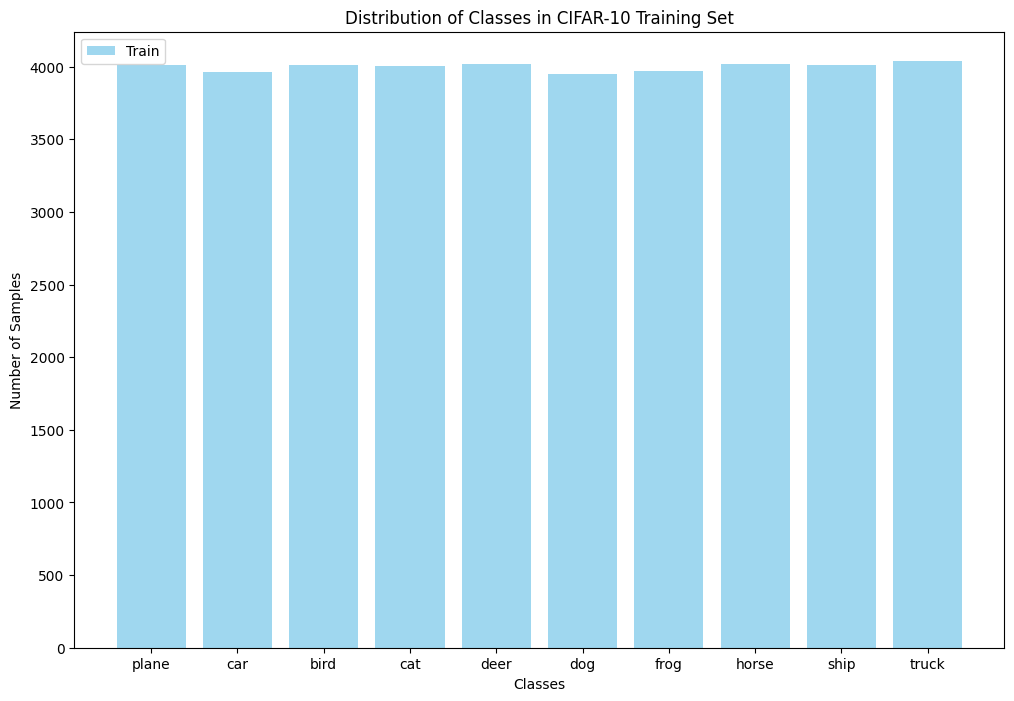

In [6]:
# 初始化计数器
class_counts = np.zeros(10, dtype=int)

# 计算训练集中每个类的样本数
for _, labels in trainloader:
    for label in labels:
        class_counts[label] += 1

# 创建柱状图
plt.figure(figsize=(12, 8))
indexes = np.arange(len(classes))
bar_width = 0.8

plt.bar(indexes, class_counts, bar_width, alpha=0.8, color='skyblue', label='Train')

plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in CIFAR-10 Training Set')
plt.xticks(indexes, classes)
plt.legend()

plt.show()

## Train

In [7]:
import copy
from tqdm import tqdm

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    the_best_model = copy.deepcopy(model.state_dict())
    the_best_acc = 0
    epochs_no_improve = 0
    early_stop = False

    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_acc': [],
        'valid_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0

        train_loop = tqdm(train_loader, leave=False)
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            train_loop.set_description(f'Epoch {epoch+1}/{num_epochs}')
            train_loop.set_postfix(loss=loss.item(), acc=100 * train_correct / train_total)

        train_acc = 100 * train_correct / train_total
        avg_train_loss = total_train_loss / len(train_loader)
        model.eval()
        total_val_loss = 0
        val_correct = 0
        val_total = 0
        val_loop = tqdm(val_loader, leave=True)
        with torch.no_grad():
            for inputs, labels in val_loop:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        avg_val_loss = total_val_loss / len(val_loader)
        history['train_loss'].append(avg_train_loss)
        history['valid_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['valid_acc'].append(val_acc)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.2f}%')

        if val_acc > the_best_acc:
            the_best_acc = val_acc
            the_best_model = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Early stopping!')
                early_stop = True
                break

    model.load_state_dict(the_best_model)
    return model, the_best_acc, history

In [8]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', color='blue')
    plt.plot(history['valid_loss'], label='Validation Loss', color='red')
    plt.title(f'Train and Valid Loss - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy', color='blue')
    plt.plot(history['valid_acc'], label='Validation Accuracy', color='red')
    plt.title(f'Train and Valid Accuracy - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [9]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

## Baseline - LeNet

In [ ]:
# Baseline
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
lenet = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet.parameters(), lr=0.001)
lenet, best_acc, history = train(lenet, trainloader, valloader, criterion, optimizer, num_epochs=50,patience=5)
print(f'LeNet Best Validation Accuracy: {best_acc:.2f}%')

Epoch 1, Train Loss: 1.5932, Train Acc: 41.53%, Validation Loss: 1.4261, Validation Acc: 49.37%
Epoch 2, Train Loss: 1.3228, Train Acc: 52.53%, Validation Loss: 1.3420, Validation Acc: 54.10%
Epoch 3, Train Loss: 1.2100, Train Acc: 56.97%, Validation Loss: 1.2251, Validation Acc: 57.34%
Epoch 4, Train Loss: 1.1324, Train Acc: 60.10%, Validation Loss: 1.2655, Validation Acc: 56.26%
Epoch 5, Train Loss: 1.0701, Train Acc: 62.34%, Validation Loss: 1.2114, Validation Acc: 58.26%
Epoch 6, Train Loss: 1.0282, Train Acc: 63.88%, Validation Loss: 1.1286, Validation Acc: 60.91%
Epoch 7, Train Loss: 0.9861, Train Acc: 65.50%, Validation Loss: 1.2395, Validation Acc: 57.93%
Epoch 8, Train Loss: 0.9547, Train Acc: 66.75%, Validation Loss: 1.2055, Validation Acc: 60.26%
Epoch 9, Train Loss: 0.9266, Train Acc: 67.57%, Validation Loss: 1.1761, Validation Acc: 59.98%
Epoch 10, Train Loss: 0.9064, Train Acc: 68.25%, Validation Loss: 1.2518, Validation Acc: 60.74%
Epoch 11, Train Loss: 0.8835, Train Acc

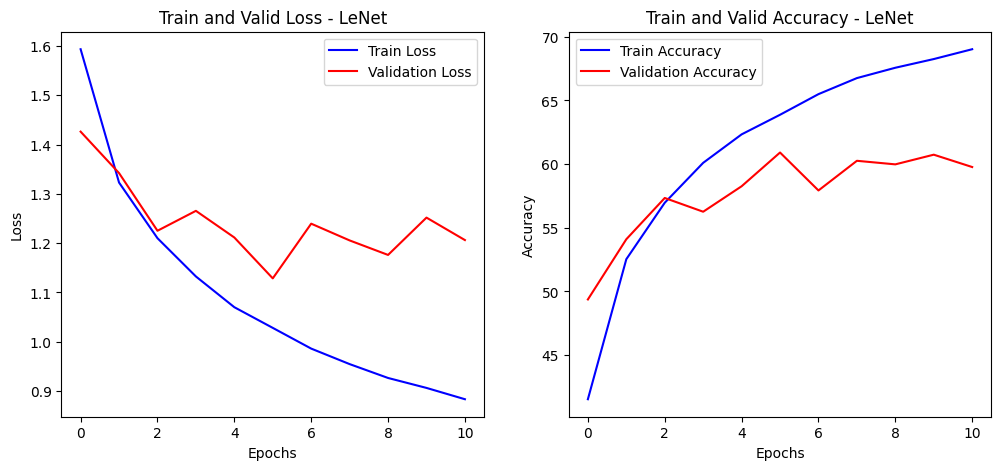

In [ ]:
plot_training_history(history,"LeNet")

In [ ]:
evaluate_model(lenet, testloader)

Accuracy on the test set: 60.48%


## AlexNet

Because the input images are only 32x32, we revise the network structure to be more suitable for 32x32 images by adjusting the kernel sizes, padding, and/or removing some pooling layers.

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the features to feed into the classifier
        x = self.classifier(x)
        return x

In [ ]:
# Instantiate the model, define loss function and optimizer
alexnet = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

# Assuming 'trainloader' and 'valloader' are defined as DataLoader instances
alexnet, best_acc, history = train(alexnet, trainloader, valloader, criterion, optimizer, num_epochs=50, patience=5)

print(f'AlexNet Best Validation Accuracy: {best_acc:.2f}%')

100%|██████████| 2500/2500 [00:05<00:00, 433.10it/s]


Epoch 1, Train Loss: 1.8682, Train Acc: 28.48%, Validation Loss: 1.6205, Validation Acc: 37.74%


100%|██████████| 2500/2500 [00:05<00:00, 441.14it/s]


Epoch 2, Train Loss: 1.6557, Train Acc: 38.41%, Validation Loss: 1.5535, Validation Acc: 42.93%


100%|██████████| 2500/2500 [00:05<00:00, 434.96it/s]


Epoch 3, Train Loss: 1.5687, Train Acc: 42.76%, Validation Loss: 1.4599, Validation Acc: 46.40%


100%|██████████| 2500/2500 [00:05<00:00, 443.86it/s]


Epoch 4, Train Loss: 1.5217, Train Acc: 44.69%, Validation Loss: 1.4421, Validation Acc: 47.13%


100%|██████████| 2500/2500 [00:05<00:00, 447.05it/s]


Epoch 5, Train Loss: 1.4969, Train Acc: 46.09%, Validation Loss: 1.3866, Validation Acc: 49.32%


100%|██████████| 2500/2500 [00:05<00:00, 453.85it/s]


Epoch 6, Train Loss: 1.4866, Train Acc: 46.64%, Validation Loss: 1.3615, Validation Acc: 51.53%


100%|██████████| 2500/2500 [00:05<00:00, 444.38it/s]


Epoch 7, Train Loss: 1.4680, Train Acc: 47.49%, Validation Loss: 1.3933, Validation Acc: 50.61%


100%|██████████| 2500/2500 [00:05<00:00, 434.31it/s]


Epoch 8, Train Loss: 1.4521, Train Acc: 48.16%, Validation Loss: 1.3682, Validation Acc: 51.98%


100%|██████████| 2500/2500 [00:05<00:00, 431.13it/s]


Epoch 9, Train Loss: 1.4351, Train Acc: 48.84%, Validation Loss: 1.3681, Validation Acc: 50.41%


100%|██████████| 2500/2500 [00:05<00:00, 435.52it/s]


Epoch 10, Train Loss: 1.4437, Train Acc: 48.53%, Validation Loss: 1.3345, Validation Acc: 52.16%


100%|██████████| 2500/2500 [00:05<00:00, 446.48it/s]


Epoch 11, Train Loss: 1.4523, Train Acc: 48.51%, Validation Loss: 1.3766, Validation Acc: 51.14%


100%|██████████| 2500/2500 [00:05<00:00, 455.32it/s]


Epoch 12, Train Loss: 1.4721, Train Acc: 49.53%, Validation Loss: 1.3256, Validation Acc: 52.84%


100%|██████████| 2500/2500 [00:05<00:00, 433.55it/s]


Epoch 13, Train Loss: 1.4476, Train Acc: 48.86%, Validation Loss: 1.3260, Validation Acc: 53.53%


100%|██████████| 2500/2500 [00:05<00:00, 441.23it/s]


Epoch 14, Train Loss: 1.4389, Train Acc: 48.98%, Validation Loss: 1.3297, Validation Acc: 52.28%


100%|██████████| 2500/2500 [00:05<00:00, 433.94it/s]


Epoch 15, Train Loss: 1.4269, Train Acc: 49.48%, Validation Loss: 1.2977, Validation Acc: 53.57%


100%|██████████| 2500/2500 [00:05<00:00, 449.52it/s]


Epoch 16, Train Loss: 1.4049, Train Acc: 49.95%, Validation Loss: 1.3354, Validation Acc: 52.00%


100%|██████████| 2500/2500 [00:05<00:00, 433.52it/s]


Epoch 17, Train Loss: 1.4328, Train Acc: 49.07%, Validation Loss: 1.4433, Validation Acc: 49.41%


100%|██████████| 2500/2500 [00:05<00:00, 429.81it/s]


Epoch 18, Train Loss: 1.3854, Train Acc: 50.35%, Validation Loss: 1.2980, Validation Acc: 54.67%


100%|██████████| 2500/2500 [00:05<00:00, 433.82it/s]


Epoch 19, Train Loss: 1.4065, Train Acc: 50.01%, Validation Loss: 1.3459, Validation Acc: 52.88%


100%|██████████| 2500/2500 [00:05<00:00, 437.43it/s]


Epoch 20, Train Loss: 1.4493, Train Acc: 48.91%, Validation Loss: 1.3284, Validation Acc: 53.70%


100%|██████████| 2500/2500 [00:05<00:00, 444.54it/s]


Epoch 21, Train Loss: 1.4005, Train Acc: 50.18%, Validation Loss: 1.3649, Validation Acc: 52.19%


100%|██████████| 2500/2500 [00:05<00:00, 452.55it/s]


Epoch 22, Train Loss: 1.3903, Train Acc: 50.50%, Validation Loss: 1.3279, Validation Acc: 53.28%


100%|██████████| 2500/2500 [00:05<00:00, 435.59it/s]

Epoch 23, Train Loss: 1.3877, Train Acc: 50.51%, Validation Loss: 1.3211, Validation Acc: 52.70%
Early stopping!
AlexNet Best Validation Accuracy: 54.67%


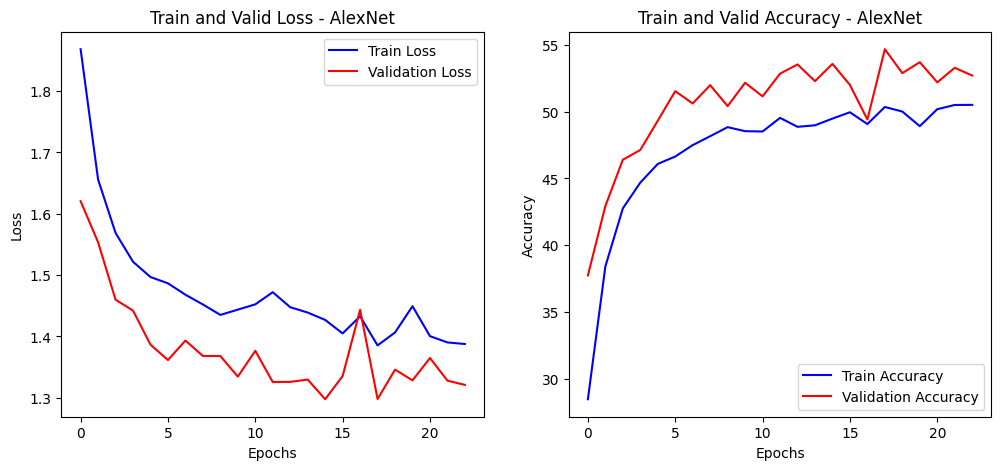

In [ ]:
plot_training_history(history,"AlexNet")

In [ ]:
evaluate_model(alexnet, testloader)

Accuracy on the test set: 55.29%


## VGG

In [ ]:
# class VGG16(nn.Module):
#     def __init__(self, num_classes=10):
#         super(VGG16, self).__init__()
#         self.features = nn.Sequential(
#             # 第一块
#             nn.Conv2d(3, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             # 第二块
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             # 第三块
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             # 第四块
#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             # 第五块
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 1 * 1, 512),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(512, 512),
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(512, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x

In [ ]:
from torchvision.models import VGG16_Weights
vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
vgg16.classifier[6] = nn.Linear(4096, 10)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 202MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)
vgg16, best_accuracy, history = train(vgg16, trainloader, valloader, criterion, optimizer, num_epochs=30, patience=5)

100%|██████████| 2500/2500 [00:12<00:00, 201.89it/s]


Epoch 1, Train Loss: 0.9022, Train Acc: 71.22%, Validation Loss: 0.9056, Validation Acc: 74.02%


100%|██████████| 2500/2500 [00:12<00:00, 203.18it/s]


Epoch 2, Train Loss: 0.5493, Train Acc: 83.33%, Validation Loss: 0.6369, Validation Acc: 80.37%


100%|██████████| 2500/2500 [00:12<00:00, 206.40it/s]


Epoch 3, Train Loss: 0.4297, Train Acc: 87.23%, Validation Loss: 0.5128, Validation Acc: 84.28%


100%|██████████| 2500/2500 [00:12<00:00, 202.90it/s]


Epoch 4, Train Loss: 0.3474, Train Acc: 89.88%, Validation Loss: 0.4831, Validation Acc: 85.97%


100%|██████████| 2500/2500 [00:12<00:00, 199.42it/s]


Epoch 5, Train Loss: 0.2930, Train Acc: 91.67%, Validation Loss: 0.8248, Validation Acc: 81.09%


100%|██████████| 2500/2500 [00:12<00:00, 202.50it/s]


Epoch 6, Train Loss: 0.2809, Train Acc: 92.25%, Validation Loss: 0.6189, Validation Acc: 82.92%


100%|██████████| 2500/2500 [00:12<00:00, 198.99it/s]


Epoch 7, Train Loss: 0.2526, Train Acc: 93.11%, Validation Loss: 0.6713, Validation Acc: 84.53%


100%|██████████| 2500/2500 [00:12<00:00, 205.48it/s]


Epoch 8, Train Loss: 0.2419, Train Acc: 93.68%, Validation Loss: 1.0120, Validation Acc: 86.16%


100%|██████████| 2500/2500 [00:12<00:00, 198.40it/s]


Epoch 9, Train Loss: 0.2618, Train Acc: 93.68%, Validation Loss: 0.6397, Validation Acc: 83.47%


100%|██████████| 2500/2500 [00:12<00:00, 202.64it/s]


Epoch 10, Train Loss: 0.2326, Train Acc: 93.89%, Validation Loss: 2.0178, Validation Acc: 84.76%


100%|██████████| 2500/2500 [00:12<00:00, 204.01it/s]


Epoch 11, Train Loss: 0.2346, Train Acc: 93.93%, Validation Loss: 0.6522, Validation Acc: 84.79%


100%|██████████| 2500/2500 [00:12<00:00, 206.21it/s]


Epoch 12, Train Loss: 0.2248, Train Acc: 94.40%, Validation Loss: 0.6431, Validation Acc: 85.55%


100%|██████████| 2500/2500 [00:12<00:00, 201.04it/s]

Epoch 13, Train Loss: 0.1888, Train Acc: 95.30%, Validation Loss: 0.7035, Validation Acc: 82.32%
Early stopping!


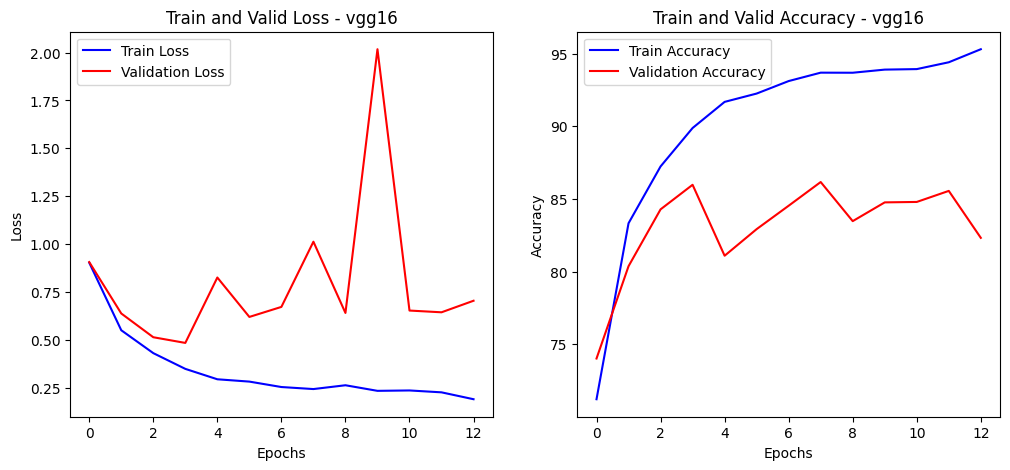

In [ ]:
plot_training_history(history,"vgg16")

In [ ]:
evaluate_model(vgg16, testloader)

Accuracy on the test set: 85.95%


In [ ]:
from torchvision.models import VGG19_Weights
vgg19 = models.vgg19(weights=VGG19_Weights.DEFAULT)
vgg19.classifier[6] = nn.Linear(4096, 10)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 86.6MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19.parameters(), lr=0.0001)
vgg19, best_accuracy, history = train(vgg19, trainloader, valloader, criterion, optimizer, num_epochs=30, patience=5)

100%|██████████| 2500/2500 [00:16<00:00, 147.98it/s]


Epoch 1, Train Loss: 1.0242, Train Acc: 67.52%, Validation Loss: 0.7328, Validation Acc: 76.83%


100%|██████████| 2500/2500 [00:16<00:00, 147.26it/s]


Epoch 2, Train Loss: 0.6529, Train Acc: 80.32%, Validation Loss: 0.6190, Validation Acc: 81.29%


100%|██████████| 2500/2500 [00:16<00:00, 147.44it/s]


Epoch 3, Train Loss: 0.5176, Train Acc: 84.79%, Validation Loss: 0.6671, Validation Acc: 79.68%


100%|██████████| 2500/2500 [00:17<00:00, 146.18it/s]


Epoch 4, Train Loss: 0.4240, Train Acc: 87.61%, Validation Loss: 0.6690, Validation Acc: 82.35%


100%|██████████| 2500/2500 [00:16<00:00, 147.62it/s]


Epoch 5, Train Loss: 0.3786, Train Acc: 89.04%, Validation Loss: 0.5470, Validation Acc: 85.08%


100%|██████████| 2500/2500 [00:16<00:00, 147.78it/s]


Epoch 6, Train Loss: 0.3858, Train Acc: 89.29%, Validation Loss: 0.8739, Validation Acc: 75.60%


100%|██████████| 2500/2500 [00:16<00:00, 148.63it/s]


Epoch 7, Train Loss: 0.3207, Train Acc: 90.81%, Validation Loss: 0.5433, Validation Acc: 83.22%


100%|██████████| 2500/2500 [00:16<00:00, 147.73it/s]


Epoch 8, Train Loss: 0.2736, Train Acc: 92.15%, Validation Loss: 2.0553, Validation Acc: 75.23%


100%|██████████| 2500/2500 [00:16<00:00, 148.27it/s]


Epoch 9, Train Loss: 0.2690, Train Acc: 92.62%, Validation Loss: 0.5945, Validation Acc: 85.34%


100%|██████████| 2500/2500 [00:16<00:00, 147.70it/s]


Epoch 10, Train Loss: 0.2621, Train Acc: 92.94%, Validation Loss: 0.6401, Validation Acc: 82.97%


100%|██████████| 2500/2500 [00:17<00:00, 147.04it/s]


Epoch 11, Train Loss: 0.3204, Train Acc: 92.04%, Validation Loss: 0.7981, Validation Acc: 84.53%


100%|██████████| 2500/2500 [00:16<00:00, 147.86it/s]


Epoch 12, Train Loss: 0.3818, Train Acc: 92.00%, Validation Loss: 1.0662, Validation Acc: 83.96%


100%|██████████| 2500/2500 [00:16<00:00, 147.39it/s]


Epoch 13, Train Loss: 0.2926, Train Acc: 92.68%, Validation Loss: 0.7058, Validation Acc: 85.49%


100%|██████████| 2500/2500 [00:16<00:00, 148.04it/s]


Epoch 14, Train Loss: 0.2603, Train Acc: 93.19%, Validation Loss: 0.6872, Validation Acc: 81.08%


100%|██████████| 2500/2500 [00:17<00:00, 145.91it/s]


Epoch 15, Train Loss: 3.1658, Train Acc: 90.94%, Validation Loss: 0.8494, Validation Acc: 83.24%


100%|██████████| 2500/2500 [00:17<00:00, 146.93it/s]


Epoch 16, Train Loss: 0.2146, Train Acc: 94.21%, Validation Loss: 1.4530, Validation Acc: 85.05%


100%|██████████| 2500/2500 [00:16<00:00, 149.36it/s]


Epoch 17, Train Loss: 0.3055, Train Acc: 91.99%, Validation Loss: 0.9365, Validation Acc: 85.17%


100%|██████████| 2500/2500 [00:16<00:00, 148.36it/s]

Epoch 18, Train Loss: 18.1360, Train Acc: 88.74%, Validation Loss: 0.6055, Validation Acc: 82.52%
Early stopping!


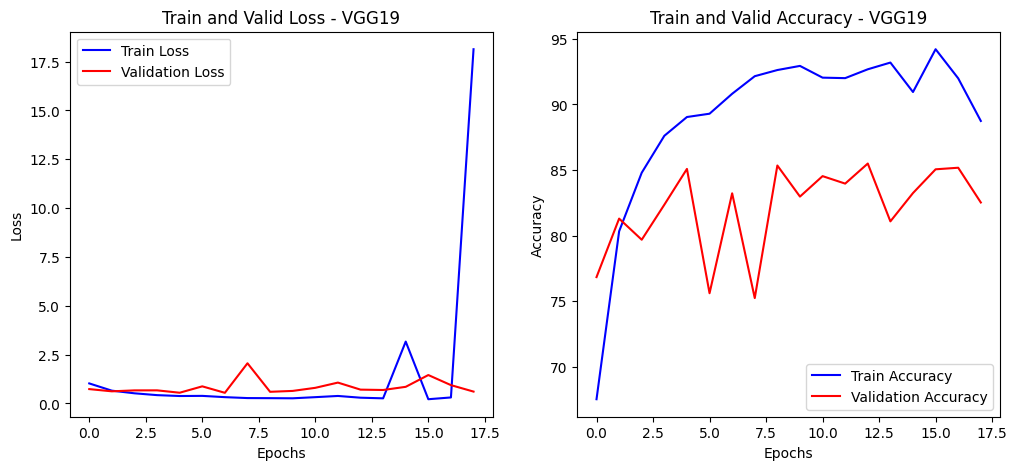

In [ ]:
plot_training_history(history,"VGG19")

In [ ]:
evaluate_model(vgg19, testloader)

Accuracy on the test set: 85.38%


## ResNet

In [ ]:
import torchvision.models as models
resnet18 = models.resnet18(weights=None)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)
resnet18, best_accuracy, history = train(resnet18, trainloader, valloader, criterion, optimizer, num_epochs=30, patience=5)

100%|██████████| 2500/2500 [00:11<00:00, 217.28it/s]


Epoch 1, Train Loss: 2.0295, Train Acc: 26.51%, Validation Loss: 1.8415, Validation Acc: 38.09%


100%|██████████| 2500/2500 [00:11<00:00, 215.19it/s]


Epoch 2, Train Loss: 1.6740, Train Acc: 39.33%, Validation Loss: 1.8945, Validation Acc: 42.01%


100%|██████████| 2500/2500 [00:11<00:00, 222.19it/s]


Epoch 3, Train Loss: 1.5151, Train Acc: 45.22%, Validation Loss: 2.1216, Validation Acc: 48.77%


100%|██████████| 2500/2500 [00:11<00:00, 221.06it/s]


Epoch 4, Train Loss: 1.3986, Train Acc: 49.89%, Validation Loss: 1.7165, Validation Acc: 51.93%


100%|██████████| 2500/2500 [00:11<00:00, 219.82it/s]


Epoch 5, Train Loss: 1.3003, Train Acc: 53.67%, Validation Loss: 2.0808, Validation Acc: 54.41%


100%|██████████| 2500/2500 [00:11<00:00, 218.48it/s]


Epoch 6, Train Loss: 1.2321, Train Acc: 56.57%, Validation Loss: 1.3235, Validation Acc: 57.71%


100%|██████████| 2500/2500 [00:11<00:00, 219.98it/s]


Epoch 7, Train Loss: 1.1568, Train Acc: 59.27%, Validation Loss: 1.3802, Validation Acc: 60.13%


100%|██████████| 2500/2500 [00:11<00:00, 224.99it/s]


Epoch 8, Train Loss: 1.0890, Train Acc: 61.77%, Validation Loss: 1.4583, Validation Acc: 61.34%


100%|██████████| 2500/2500 [00:11<00:00, 225.77it/s]


Epoch 9, Train Loss: 1.0282, Train Acc: 64.19%, Validation Loss: 1.6879, Validation Acc: 59.58%


100%|██████████| 2500/2500 [00:11<00:00, 222.85it/s]


Epoch 10, Train Loss: 1.0074, Train Acc: 64.80%, Validation Loss: 1.7417, Validation Acc: 61.26%


100%|██████████| 2500/2500 [00:11<00:00, 226.48it/s]


Epoch 11, Train Loss: 0.9672, Train Acc: 66.47%, Validation Loss: 2.7951, Validation Acc: 56.56%


100%|██████████| 2500/2500 [00:11<00:00, 226.13it/s]


Epoch 12, Train Loss: 0.9220, Train Acc: 68.11%, Validation Loss: 1.2391, Validation Acc: 63.55%


100%|██████████| 2500/2500 [00:10<00:00, 229.07it/s]


Epoch 13, Train Loss: 0.8809, Train Acc: 69.47%, Validation Loss: 3.7162, Validation Acc: 60.39%


100%|██████████| 2500/2500 [00:11<00:00, 223.35it/s]


Epoch 14, Train Loss: 0.8345, Train Acc: 71.25%, Validation Loss: 2.2513, Validation Acc: 62.81%


100%|██████████| 2500/2500 [00:11<00:00, 222.79it/s]


Epoch 15, Train Loss: 0.8145, Train Acc: 71.78%, Validation Loss: 4.8046, Validation Acc: 61.39%


100%|██████████| 2500/2500 [00:10<00:00, 229.94it/s]


Epoch 16, Train Loss: 0.7873, Train Acc: 73.06%, Validation Loss: 1.6082, Validation Acc: 67.70%


100%|██████████| 2500/2500 [00:11<00:00, 227.11it/s]


Epoch 17, Train Loss: 0.7258, Train Acc: 75.08%, Validation Loss: 9.4835, Validation Acc: 62.21%


100%|██████████| 2500/2500 [00:11<00:00, 220.25it/s]


Epoch 18, Train Loss: 0.6979, Train Acc: 76.44%, Validation Loss: 3.6921, Validation Acc: 62.37%


100%|██████████| 2500/2500 [00:10<00:00, 230.94it/s]


Epoch 19, Train Loss: 0.6722, Train Acc: 76.91%, Validation Loss: 3.1792, Validation Acc: 63.88%


100%|██████████| 2500/2500 [00:11<00:00, 215.99it/s]


Epoch 20, Train Loss: 0.6476, Train Acc: 77.74%, Validation Loss: 9.6738, Validation Acc: 62.48%


100%|██████████| 2500/2500 [00:11<00:00, 226.13it/s]

Epoch 21, Train Loss: 0.6096, Train Acc: 78.96%, Validation Loss: 3.2884, Validation Acc: 66.72%
Early stopping!


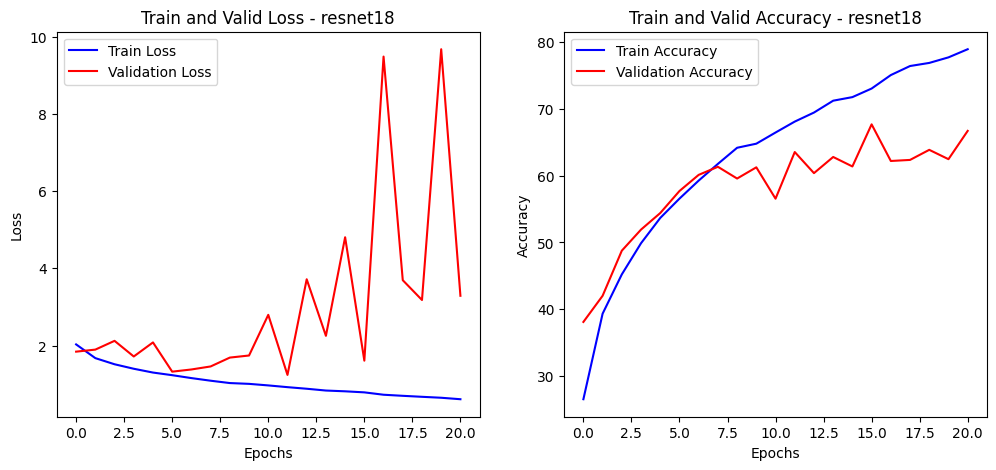

In [ ]:
plot_training_history(history, "resnet18")

In [ ]:
evaluate_model(resnet18, testloader)

Accuracy on the test set: 66.90%


In [ ]:
from torchvision.models import ResNet34_Weights

resnet34 = models.resnet34(weights=ResNet34_Weights.DEFAULT)
resnet34.fc = nn.Linear(resnet34.fc.in_features, 10)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 213MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet34.parameters(), lr=0.0001)
resnet34, best_accuracy, history = train(resnet34, trainloader, valloader, criterion, optimizer, num_epochs=30, patience=5)

100%|██████████| 2500/2500 [00:16<00:00, 148.05it/s]


Epoch 1, Train Loss: 1.6181, Train Acc: 44.48%, Validation Loss: 1.2383, Validation Acc: 63.30%


100%|██████████| 2500/2500 [00:16<00:00, 152.02it/s]


Epoch 2, Train Loss: 1.1797, Train Acc: 61.14%, Validation Loss: 1.0566, Validation Acc: 71.09%


100%|██████████| 2500/2500 [00:16<00:00, 150.09it/s]


Epoch 3, Train Loss: 0.9477, Train Acc: 69.16%, Validation Loss: 0.9675, Validation Acc: 72.25%


100%|██████████| 2500/2500 [00:16<00:00, 148.57it/s]


Epoch 4, Train Loss: 0.8050, Train Acc: 74.23%, Validation Loss: 0.7701, Validation Acc: 77.11%


100%|██████████| 2500/2500 [00:16<00:00, 149.39it/s]


Epoch 5, Train Loss: 0.6998, Train Acc: 77.48%, Validation Loss: 0.8157, Validation Acc: 73.89%


100%|██████████| 2500/2500 [00:16<00:00, 149.09it/s]


Epoch 6, Train Loss: 0.5965, Train Acc: 80.81%, Validation Loss: 0.6961, Validation Acc: 77.99%


100%|██████████| 2500/2500 [00:16<00:00, 149.36it/s]


Epoch 7, Train Loss: 0.5293, Train Acc: 83.14%, Validation Loss: 0.6366, Validation Acc: 80.35%


100%|██████████| 2500/2500 [00:16<00:00, 148.29it/s]


Epoch 8, Train Loss: 0.4461, Train Acc: 85.79%, Validation Loss: 0.6609, Validation Acc: 79.77%


100%|██████████| 2500/2500 [00:16<00:00, 149.34it/s]


Epoch 9, Train Loss: 0.3907, Train Acc: 87.56%, Validation Loss: 0.8130, Validation Acc: 77.67%


100%|██████████| 2500/2500 [00:16<00:00, 148.40it/s]


Epoch 10, Train Loss: 0.3393, Train Acc: 89.14%, Validation Loss: 0.6794, Validation Acc: 78.76%


100%|██████████| 2500/2500 [00:16<00:00, 148.82it/s]


Epoch 11, Train Loss: 0.2937, Train Acc: 90.77%, Validation Loss: 0.6408, Validation Acc: 79.45%


100%|██████████| 2500/2500 [00:16<00:00, 147.85it/s]


Epoch 12, Train Loss: 0.2526, Train Acc: 92.06%, Validation Loss: 0.6064, Validation Acc: 81.06%


100%|██████████| 2500/2500 [00:16<00:00, 147.19it/s]


Epoch 13, Train Loss: 0.2265, Train Acc: 92.78%, Validation Loss: 0.6715, Validation Acc: 79.95%


100%|██████████| 2500/2500 [00:16<00:00, 149.89it/s]


Epoch 14, Train Loss: 0.1992, Train Acc: 93.77%, Validation Loss: 0.6351, Validation Acc: 80.20%


100%|██████████| 2500/2500 [00:16<00:00, 150.18it/s]


Epoch 15, Train Loss: 0.1836, Train Acc: 94.34%, Validation Loss: 0.6999, Validation Acc: 80.11%


100%|██████████| 2500/2500 [00:17<00:00, 146.52it/s]


Epoch 16, Train Loss: 0.1632, Train Acc: 94.94%, Validation Loss: 0.8140, Validation Acc: 79.86%


100%|██████████| 2500/2500 [00:16<00:00, 149.43it/s]

Epoch 17, Train Loss: 0.1489, Train Acc: 95.42%, Validation Loss: 0.9437, Validation Acc: 75.90%
Early stopping!


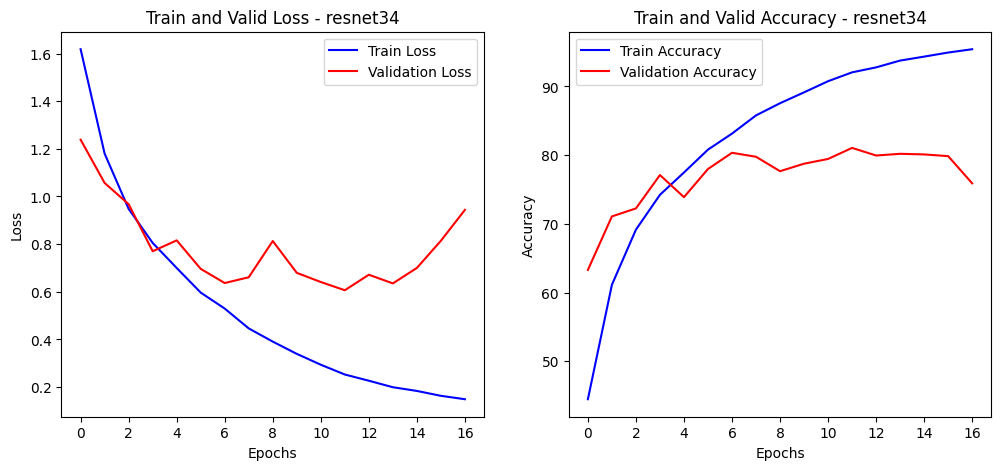

In [ ]:
plot_training_history(history,"resnet34")

In [ ]:
evaluate_model(resnet34, testloader)

Accuracy on the test set: 80.66%


In [ ]:
from torchvision.models import ResNet50_Weights
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)
resnet50, best_accuracy, history = train(resnet50, trainloader, valloader, criterion, optimizer, num_epochs=30, patience=5)

100%|██████████| 2500/2500 [00:21<00:00, 114.88it/s]


Epoch 1, Train Loss: 1.8512, Train Acc: 32.92%, Validation Loss: 1.8494, Validation Acc: 58.82%


100%|██████████| 2500/2500 [00:21<00:00, 117.86it/s]


Epoch 2, Train Loss: 1.2936, Train Acc: 56.35%, Validation Loss: 1.1249, Validation Acc: 71.39%


100%|██████████| 2500/2500 [00:21<00:00, 115.03it/s]


Epoch 3, Train Loss: 1.0424, Train Acc: 65.56%, Validation Loss: 1.1316, Validation Acc: 72.24%


100%|██████████| 2500/2500 [00:21<00:00, 116.92it/s]


Epoch 4, Train Loss: 0.8888, Train Acc: 70.84%, Validation Loss: 1.7494, Validation Acc: 65.82%


100%|██████████| 2500/2500 [00:21<00:00, 114.10it/s]


Epoch 5, Train Loss: 0.7713, Train Acc: 74.79%, Validation Loss: 1.8552, Validation Acc: 69.50%


100%|██████████| 2500/2500 [00:21<00:00, 115.72it/s]


Epoch 6, Train Loss: 0.6741, Train Acc: 77.95%, Validation Loss: 6.9209, Validation Acc: 60.05%


100%|██████████| 2500/2500 [00:21<00:00, 115.31it/s]


Epoch 7, Train Loss: 0.6072, Train Acc: 80.25%, Validation Loss: 1.8807, Validation Acc: 65.45%


100%|██████████| 2500/2500 [00:21<00:00, 115.42it/s]

Epoch 8, Train Loss: 0.5421, Train Acc: 82.61%, Validation Loss: 2.1246, Validation Acc: 66.68%
Early stopping!


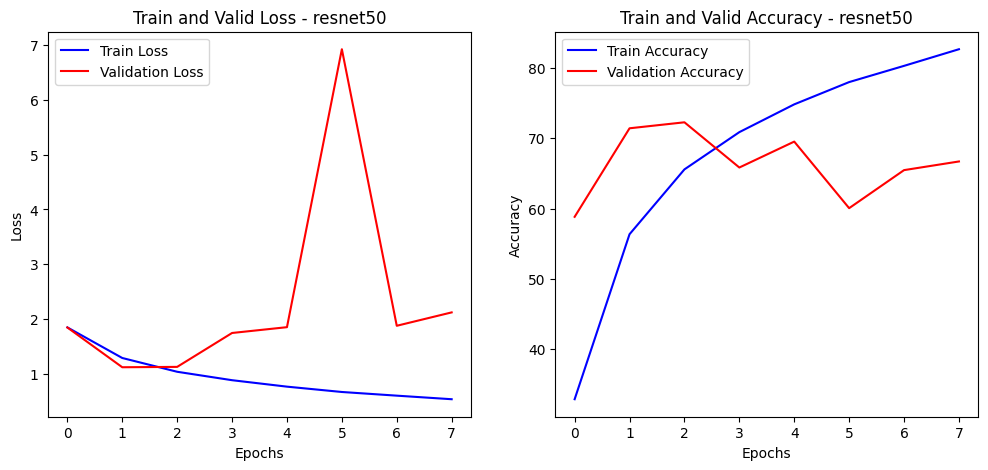

In [ ]:
plot_training_history(history,"resnet50")

In [ ]:
evaluate_model(resnet50, testloader)

Accuracy on the test set: 72.39%


## DenseNet

In [ ]:
from torchvision.models import DenseNet121_Weights
densenet = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
densenet.classifier = nn.Linear(densenet.classifier.in_features, 10)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 200MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet.parameters(), lr=0.0001)
densenet, best_accuracy, history = train(densenet, trainloader, valloader, criterion, optimizer, num_epochs=50, patience=5)

100%|██████████| 2500/2500 [00:50<00:00, 49.42it/s]


Epoch 1, Train Loss: 1.5296, Train Acc: 46.64%, Validation Loss: 1.0247, Validation Acc: 66.60%


100%|██████████| 2500/2500 [00:50<00:00, 49.47it/s]


Epoch 2, Train Loss: 1.1489, Train Acc: 61.74%, Validation Loss: 0.8757, Validation Acc: 73.86%


100%|██████████| 2500/2500 [00:51<00:00, 48.86it/s]


Epoch 3, Train Loss: 0.9455, Train Acc: 68.93%, Validation Loss: 0.8314, Validation Acc: 75.66%


100%|██████████| 2500/2500 [00:50<00:00, 49.31it/s]


Epoch 4, Train Loss: 0.8162, Train Acc: 73.59%, Validation Loss: 0.7506, Validation Acc: 77.34%


100%|██████████| 2500/2500 [00:49<00:00, 50.02it/s]


Epoch 5, Train Loss: 0.7074, Train Acc: 77.14%, Validation Loss: 0.6764, Validation Acc: 80.06%


100%|██████████| 2500/2500 [00:50<00:00, 49.28it/s]


Epoch 6, Train Loss: 0.6141, Train Acc: 80.49%, Validation Loss: 0.6842, Validation Acc: 80.01%


100%|██████████| 2500/2500 [00:50<00:00, 49.91it/s]


Epoch 7, Train Loss: 0.5420, Train Acc: 82.78%, Validation Loss: 0.6396, Validation Acc: 81.44%


100%|██████████| 2500/2500 [00:49<00:00, 50.11it/s]


Epoch 8, Train Loss: 0.4777, Train Acc: 84.83%, Validation Loss: 0.6371, Validation Acc: 80.01%


100%|██████████| 2500/2500 [00:50<00:00, 49.87it/s]


Epoch 9, Train Loss: 0.4252, Train Acc: 86.33%, Validation Loss: 0.6210, Validation Acc: 80.28%


100%|██████████| 2500/2500 [00:50<00:00, 49.62it/s]


Epoch 10, Train Loss: 0.3851, Train Acc: 87.62%, Validation Loss: 0.6948, Validation Acc: 80.71%


100%|██████████| 2500/2500 [00:49<00:00, 50.25it/s]


Epoch 11, Train Loss: 0.3486, Train Acc: 88.82%, Validation Loss: 0.6180, Validation Acc: 80.93%


100%|██████████| 2500/2500 [00:50<00:00, 49.90it/s]


Epoch 12, Train Loss: 0.3122, Train Acc: 90.02%, Validation Loss: 0.5222, Validation Acc: 83.75%


100%|██████████| 2500/2500 [00:49<00:00, 50.17it/s]


Epoch 13, Train Loss: 0.2816, Train Acc: 90.98%, Validation Loss: 0.5684, Validation Acc: 81.57%


100%|██████████| 2500/2500 [00:50<00:00, 49.49it/s]


Epoch 14, Train Loss: 0.2582, Train Acc: 91.73%, Validation Loss: 0.5878, Validation Acc: 82.29%


100%|██████████| 2500/2500 [00:50<00:00, 49.08it/s]


Epoch 15, Train Loss: 0.2399, Train Acc: 92.28%, Validation Loss: 0.5566, Validation Acc: 83.08%


100%|██████████| 2500/2500 [00:50<00:00, 49.77it/s]


Epoch 16, Train Loss: 0.2090, Train Acc: 93.34%, Validation Loss: 0.8650, Validation Acc: 81.09%


100%|██████████| 2500/2500 [00:51<00:00, 48.84it/s]

Epoch 17, Train Loss: 0.2020, Train Acc: 93.69%, Validation Loss: 0.6465, Validation Acc: 81.69%
Early stopping!


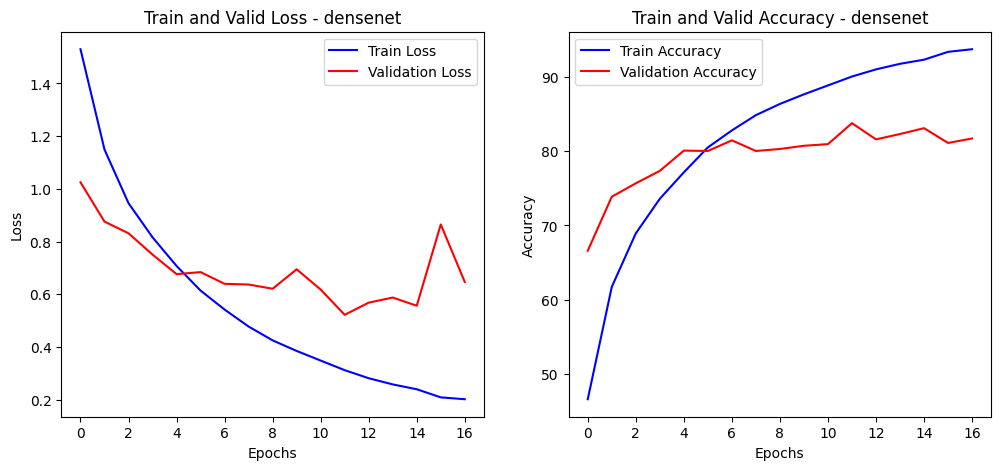

In [ ]:
plot_training_history(history,"densenet")

In [ ]:
evaluate_model(densenet, testloader)

Accuracy on the test set: 82.91%


## HyperParameter Tuning

#### Learning rate

In [ ]:
# Define learning rates and optimizers
learning_rates = [0.001, 0.0001]
optimizers = {
    'SGD': lambda lr: optim.SGD(vgg16.parameters(), lr=lr, momentum=0.9),
    'Adam': lambda lr: optim.Adam(vgg16.parameters(), lr=lr),
    'RMSprop': lambda lr: optim.RMSprop(vgg16.parameters(), lr=lr)
}

histories = {}

In [ ]:
from torchvision.models import VGG16_Weights

# Running the training for each optimizer and learning rate combination
for name, opt_func in optimizers.items():
    for lr in learning_rates:
        print(f"Training with {name} at learning rate: {lr}")
        vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
        vgg16.classifier[6] = nn.Linear(4096, 10)
        optimizer = opt_func(lr)
        criterion = nn.CrossEntropyLoss()
        _,_,history = train(vgg16, trainloader, valloader, criterion, optimizer, num_epochs=10, patience=3)
        histories[(name, lr)] = history

Training with SGD at learning rate: 0.001


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 203MB/s]
100%|██████████| 2500/2500 [00:08<00:00, 299.22it/s]


Epoch 1, Train Loss: 0.9327, Train Acc: 69.27%, Validation Loss: 0.7935, Validation Acc: 74.47%


100%|██████████| 2500/2500 [00:08<00:00, 288.17it/s]


Epoch 2, Train Loss: 0.5445, Train Acc: 82.64%, Validation Loss: 0.5408, Validation Acc: 82.22%


100%|██████████| 2500/2500 [00:08<00:00, 288.85it/s]


Epoch 3, Train Loss: 0.3964, Train Acc: 87.36%, Validation Loss: 0.5325, Validation Acc: 83.41%


100%|██████████| 2500/2500 [00:08<00:00, 294.10it/s]


Epoch 4, Train Loss: 0.3090, Train Acc: 90.14%, Validation Loss: 0.5162, Validation Acc: 83.92%


100%|██████████| 2500/2500 [00:08<00:00, 288.77it/s]


Epoch 5, Train Loss: 0.2411, Train Acc: 92.42%, Validation Loss: 0.4858, Validation Acc: 85.60%


100%|██████████| 2500/2500 [00:08<00:00, 291.90it/s]


Epoch 6, Train Loss: 0.2017, Train Acc: 93.59%, Validation Loss: 0.4649, Validation Acc: 85.84%


100%|██████████| 2500/2500 [00:08<00:00, 294.19it/s]


Epoch 7, Train Loss: 0.1670, Train Acc: 94.80%, Validation Loss: 0.5044, Validation Acc: 84.95%


100%|██████████| 2500/2500 [00:08<00:00, 298.76it/s]


Epoch 8, Train Loss: 0.1434, Train Acc: 95.55%, Validation Loss: 0.5171, Validation Acc: 86.90%


100%|██████████| 2500/2500 [00:08<00:00, 289.55it/s]


Epoch 9, Train Loss: 0.1181, Train Acc: 96.25%, Validation Loss: 0.5455, Validation Acc: 86.22%


100%|██████████| 2500/2500 [00:08<00:00, 292.89it/s]


Epoch 10, Train Loss: 0.1133, Train Acc: 96.55%, Validation Loss: 0.5013, Validation Acc: 86.42%
Training with SGD at learning rate: 0.0001


100%|██████████| 2500/2500 [00:08<00:00, 300.09it/s]


Epoch 1, Train Loss: 0.7341, Train Acc: 75.19%, Validation Loss: 0.4937, Validation Acc: 83.30%


100%|██████████| 2500/2500 [00:08<00:00, 285.07it/s]


Epoch 2, Train Loss: 0.4131, Train Acc: 85.99%, Validation Loss: 0.4494, Validation Acc: 85.10%


100%|██████████| 2500/2500 [00:08<00:00, 299.21it/s]


Epoch 3, Train Loss: 0.2850, Train Acc: 90.42%, Validation Loss: 0.4541, Validation Acc: 85.46%


100%|██████████| 2500/2500 [00:08<00:00, 290.99it/s]


Epoch 4, Train Loss: 0.1943, Train Acc: 93.39%, Validation Loss: 0.4080, Validation Acc: 87.71%


100%|██████████| 2500/2500 [00:08<00:00, 291.23it/s]


Epoch 5, Train Loss: 0.1332, Train Acc: 95.45%, Validation Loss: 0.5022, Validation Acc: 86.23%


100%|██████████| 2500/2500 [00:08<00:00, 286.70it/s]


Epoch 6, Train Loss: 0.0950, Train Acc: 96.83%, Validation Loss: 0.4830, Validation Acc: 87.62%


100%|██████████| 2500/2500 [00:08<00:00, 291.02it/s]


Epoch 7, Train Loss: 0.0616, Train Acc: 98.01%, Validation Loss: 0.5080, Validation Acc: 87.85%


100%|██████████| 2500/2500 [00:08<00:00, 296.58it/s]


Epoch 8, Train Loss: 0.0548, Train Acc: 98.20%, Validation Loss: 0.5443, Validation Acc: 88.06%


100%|██████████| 2500/2500 [00:08<00:00, 295.14it/s]


Epoch 9, Train Loss: 0.0428, Train Acc: 98.64%, Validation Loss: 0.5881, Validation Acc: 87.34%


100%|██████████| 2500/2500 [00:08<00:00, 296.20it/s]


Epoch 10, Train Loss: 0.0380, Train Acc: 98.70%, Validation Loss: 0.5688, Validation Acc: 88.24%
Training with Adam at learning rate: 0.001


100%|██████████| 2500/2500 [00:08<00:00, 284.41it/s]


Epoch 1, Train Loss: 2.3149, Train Acc: 9.87%, Validation Loss: 2.3091, Validation Acc: 9.91%


100%|██████████| 2500/2500 [00:08<00:00, 291.51it/s]


Epoch 2, Train Loss: 2.3053, Train Acc: 9.89%, Validation Loss: 2.3036, Validation Acc: 9.94%


100%|██████████| 2500/2500 [00:08<00:00, 292.92it/s]


Epoch 3, Train Loss: 2.3036, Train Acc: 9.85%, Validation Loss: 2.3027, Validation Acc: 10.33%


100%|██████████| 2500/2500 [00:08<00:00, 281.31it/s]


Epoch 4, Train Loss: 2.3033, Train Acc: 10.07%, Validation Loss: 2.3030, Validation Acc: 9.56%


100%|██████████| 2500/2500 [00:08<00:00, 282.55it/s]


Epoch 5, Train Loss: 2.3031, Train Acc: 9.95%, Validation Loss: 2.3031, Validation Acc: 9.56%


100%|██████████| 2500/2500 [00:08<00:00, 287.48it/s]


Epoch 6, Train Loss: 2.3031, Train Acc: 9.86%, Validation Loss: 2.3028, Validation Acc: 9.91%
Early stopping!
Training with Adam at learning rate: 0.0001


100%|██████████| 2500/2500 [00:08<00:00, 296.93it/s]


Epoch 1, Train Loss: 0.9317, Train Acc: 69.88%, Validation Loss: 0.7675, Validation Acc: 76.93%


100%|██████████| 2500/2500 [00:08<00:00, 292.48it/s]


Epoch 2, Train Loss: 0.5710, Train Acc: 82.72%, Validation Loss: 0.5538, Validation Acc: 82.55%


100%|██████████| 2500/2500 [00:08<00:00, 287.00it/s]


Epoch 3, Train Loss: 0.4284, Train Acc: 87.09%, Validation Loss: 0.5809, Validation Acc: 83.44%


100%|██████████| 2500/2500 [00:08<00:00, 282.23it/s]


Epoch 4, Train Loss: 0.3608, Train Acc: 89.47%, Validation Loss: 0.6051, Validation Acc: 84.10%


100%|██████████| 2500/2500 [00:08<00:00, 294.20it/s]


Epoch 5, Train Loss: 0.3080, Train Acc: 91.08%, Validation Loss: 0.6058, Validation Acc: 85.97%


100%|██████████| 2500/2500 [00:08<00:00, 289.60it/s]


Epoch 6, Train Loss: 0.2860, Train Acc: 91.94%, Validation Loss: 0.5338, Validation Acc: 84.67%


100%|██████████| 2500/2500 [00:08<00:00, 288.66it/s]


Epoch 7, Train Loss: 0.2876, Train Acc: 92.58%, Validation Loss: 0.9820, Validation Acc: 85.67%


100%|██████████| 2500/2500 [00:08<00:00, 290.09it/s]


Epoch 8, Train Loss: 0.2485, Train Acc: 93.47%, Validation Loss: 0.7957, Validation Acc: 83.54%
Early stopping!
Training with RMSprop at learning rate: 0.001


100%|██████████| 2500/2500 [00:08<00:00, 295.90it/s]


Epoch 1, Train Loss: 72237.8928, Train Acc: 9.91%, Validation Loss: 2.3061, Validation Acc: 9.79%


100%|██████████| 2500/2500 [00:08<00:00, 292.48it/s]


Epoch 2, Train Loss: 2.3074, Train Acc: 9.87%, Validation Loss: 2.3046, Validation Acc: 9.91%


100%|██████████| 2500/2500 [00:08<00:00, 279.94it/s]


Epoch 3, Train Loss: 2.3038, Train Acc: 9.88%, Validation Loss: 2.3033, Validation Acc: 10.21%


100%|██████████| 2500/2500 [00:08<00:00, 289.76it/s]


Epoch 4, Train Loss: 2.3033, Train Acc: 10.04%, Validation Loss: 2.3029, Validation Acc: 10.32%


100%|██████████| 2500/2500 [00:08<00:00, 291.26it/s]


Epoch 5, Train Loss: 2.3030, Train Acc: 9.74%, Validation Loss: 2.3026, Validation Acc: 9.99%


100%|██████████| 2500/2500 [00:08<00:00, 289.90it/s]


Epoch 6, Train Loss: 2.3031, Train Acc: 9.98%, Validation Loss: 2.3029, Validation Acc: 9.91%


100%|██████████| 2500/2500 [00:08<00:00, 291.60it/s]


Epoch 7, Train Loss: 2.3031, Train Acc: 9.76%, Validation Loss: 2.3027, Validation Acc: 9.91%
Early stopping!
Training with RMSprop at learning rate: 0.0001


100%|██████████| 2500/2500 [00:08<00:00, 281.06it/s]


Epoch 1, Train Loss: 0.9901, Train Acc: 68.26%, Validation Loss: 0.7663, Validation Acc: 77.36%


100%|██████████| 2500/2500 [00:08<00:00, 286.30it/s]


Epoch 2, Train Loss: 0.7949, Train Acc: 77.71%, Validation Loss: 0.6500, Validation Acc: 80.72%


100%|██████████| 2500/2500 [00:08<00:00, 293.56it/s]


Epoch 3, Train Loss: 0.8517, Train Acc: 76.53%, Validation Loss: 1.1417, Validation Acc: 56.18%


100%|██████████| 2500/2500 [00:08<00:00, 293.30it/s]


Epoch 4, Train Loss: 1.2114, Train Acc: 69.88%, Validation Loss: 1.3107, Validation Acc: 56.17%


100%|██████████| 2500/2500 [00:08<00:00, 298.82it/s]

Epoch 5, Train Loss: 1.9011, Train Acc: 64.61%, Validation Loss: 1.4109, Validation Acc: 51.78%
Early stopping!


In [ ]:
vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
vgg16.classifier[6] = nn.Linear(4096, 10)
optimizer = optim.Adam(vgg16.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
_,_,history1 = train(vgg16, trainloader, valloader, criterion, optimizer, num_epochs=15, patience=5)

100%|██████████| 2500/2500 [00:08<00:00, 288.33it/s]


Epoch 1, Train Loss: 0.7602, Train Acc: 73.98%, Validation Loss: 0.5132, Validation Acc: 82.42%


100%|██████████| 2500/2500 [00:08<00:00, 286.45it/s]


Epoch 2, Train Loss: 0.3974, Train Acc: 86.57%, Validation Loss: 0.4366, Validation Acc: 85.48%


100%|██████████| 2500/2500 [00:08<00:00, 285.19it/s]


Epoch 3, Train Loss: 0.2441, Train Acc: 91.75%, Validation Loss: 0.4405, Validation Acc: 86.51%


100%|██████████| 2500/2500 [00:08<00:00, 283.68it/s]


Epoch 4, Train Loss: 0.1505, Train Acc: 94.70%, Validation Loss: 0.5129, Validation Acc: 86.30%


100%|██████████| 2500/2500 [00:08<00:00, 284.85it/s]


Epoch 5, Train Loss: 0.0987, Train Acc: 96.65%, Validation Loss: 0.6027, Validation Acc: 86.51%


100%|██████████| 2500/2500 [00:08<00:00, 290.31it/s]


Epoch 6, Train Loss: 0.0752, Train Acc: 97.58%, Validation Loss: 0.6637, Validation Acc: 86.45%


100%|██████████| 2500/2500 [00:08<00:00, 288.59it/s]


Epoch 7, Train Loss: 0.0599, Train Acc: 98.08%, Validation Loss: 0.7606, Validation Acc: 85.93%


100%|██████████| 2500/2500 [00:08<00:00, 282.85it/s]


Epoch 8, Train Loss: 0.0544, Train Acc: 98.38%, Validation Loss: 0.8471, Validation Acc: 86.64%


100%|██████████| 2500/2500 [00:08<00:00, 288.97it/s]


Epoch 9, Train Loss: 0.0507, Train Acc: 98.44%, Validation Loss: 0.7662, Validation Acc: 86.23%


100%|██████████| 2500/2500 [00:08<00:00, 294.05it/s]


Epoch 10, Train Loss: 0.0448, Train Acc: 98.72%, Validation Loss: 0.8342, Validation Acc: 86.39%


100%|██████████| 2500/2500 [00:09<00:00, 274.97it/s]


Epoch 11, Train Loss: 0.0411, Train Acc: 98.83%, Validation Loss: 0.8505, Validation Acc: 86.16%


100%|██████████| 2500/2500 [00:08<00:00, 286.30it/s]


Epoch 12, Train Loss: 0.0414, Train Acc: 98.84%, Validation Loss: 0.8901, Validation Acc: 86.19%


100%|██████████| 2500/2500 [00:08<00:00, 285.48it/s]


Epoch 13, Train Loss: 0.0372, Train Acc: 98.92%, Validation Loss: 0.7943, Validation Acc: 87.25%


100%|██████████| 2500/2500 [00:08<00:00, 286.65it/s]


Epoch 14, Train Loss: 0.0365, Train Acc: 99.05%, Validation Loss: 0.8488, Validation Acc: 86.35%


100%|██████████| 2500/2500 [00:08<00:00, 284.57it/s]

Epoch 15, Train Loss: 0.0367, Train Acc: 99.02%, Validation Loss: 0.8978, Validation Acc: 87.32%


In [ ]:
histories[("Adam", 0.00001)] = history1

In [ ]:
vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
vgg16.classifier[6] = nn.Linear(4096, 10)
optimizer = optim.RMSprop(vgg16.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
_,_,history2 = train(vgg16, trainloader, valloader, criterion, optimizer, num_epochs=15, patience=5)

100%|██████████| 2500/2500 [00:08<00:00, 282.81it/s]


Epoch 1, Train Loss: 0.7740, Train Acc: 73.72%, Validation Loss: 0.5301, Validation Acc: 82.51%


100%|██████████| 2500/2500 [00:08<00:00, 283.98it/s]


Epoch 2, Train Loss: 0.4342, Train Acc: 85.68%, Validation Loss: 0.5298, Validation Acc: 83.85%


100%|██████████| 2500/2500 [00:08<00:00, 285.98it/s]


Epoch 3, Train Loss: 0.2984, Train Acc: 90.37%, Validation Loss: 0.5307, Validation Acc: 84.80%


100%|██████████| 2500/2500 [00:08<00:00, 292.11it/s]


Epoch 4, Train Loss: 0.2138, Train Acc: 93.35%, Validation Loss: 0.7363, Validation Acc: 85.54%


100%|██████████| 2500/2500 [00:09<00:00, 274.60it/s]


Epoch 5, Train Loss: 0.1740, Train Acc: 94.97%, Validation Loss: 0.7956, Validation Acc: 85.34%


100%|██████████| 2500/2500 [00:08<00:00, 295.16it/s]


Epoch 6, Train Loss: 0.1453, Train Acc: 95.89%, Validation Loss: 0.9202, Validation Acc: 85.66%


100%|██████████| 2500/2500 [00:08<00:00, 288.89it/s]


Epoch 7, Train Loss: 0.1306, Train Acc: 96.58%, Validation Loss: 1.5269, Validation Acc: 85.69%


100%|██████████| 2500/2500 [00:08<00:00, 290.45it/s]


Epoch 8, Train Loss: 0.1271, Train Acc: 97.03%, Validation Loss: 1.3782, Validation Acc: 84.25%


100%|██████████| 2500/2500 [00:08<00:00, 286.11it/s]


Epoch 9, Train Loss: 0.1298, Train Acc: 97.17%, Validation Loss: 1.2653, Validation Acc: 85.62%


100%|██████████| 2500/2500 [00:08<00:00, 291.04it/s]


Epoch 10, Train Loss: 0.1278, Train Acc: 97.27%, Validation Loss: 1.4717, Validation Acc: 86.35%


100%|██████████| 2500/2500 [00:08<00:00, 290.94it/s]


Epoch 11, Train Loss: 0.1181, Train Acc: 97.34%, Validation Loss: 1.4502, Validation Acc: 83.44%


100%|██████████| 2500/2500 [00:09<00:00, 274.72it/s]


Epoch 12, Train Loss: 0.1225, Train Acc: 97.60%, Validation Loss: 1.8323, Validation Acc: 86.72%


100%|██████████| 2500/2500 [00:08<00:00, 290.56it/s]


Epoch 13, Train Loss: 0.1163, Train Acc: 97.47%, Validation Loss: 2.1301, Validation Acc: 85.90%


100%|██████████| 2500/2500 [00:08<00:00, 282.32it/s]


Epoch 14, Train Loss: 0.1231, Train Acc: 97.58%, Validation Loss: 2.1580, Validation Acc: 85.47%


100%|██████████| 2500/2500 [00:08<00:00, 290.17it/s]

Epoch 15, Train Loss: 0.1331, Train Acc: 97.63%, Validation Loss: 1.7478, Validation Acc: 86.64%


In [ ]:
histories[("RMSprop", 0.00001)] = history2

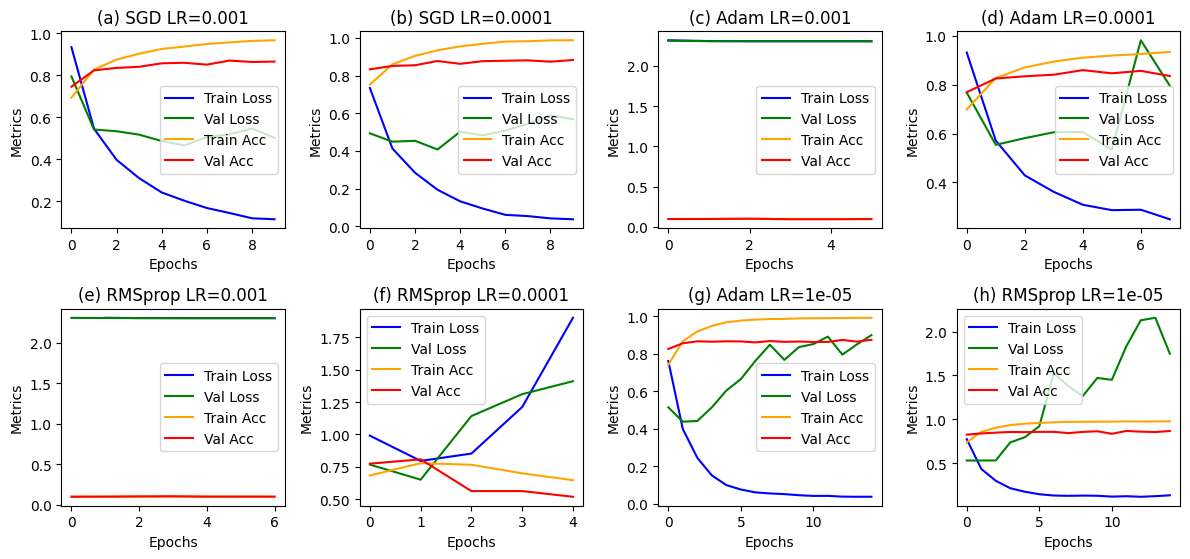

In [ ]:
import matplotlib.pyplot as plt

# Create subplots with 3 rows and 2 columns, and set the figure size to 6x9 inches
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Initialize a counter for the plot index
plot_index = 0

# Iterate through histories to plot each subplot
for (name, lr), history in histories.items():
    ax = axes[plot_index]

    # Convert train_acc and valid_acc from percentages to fractions
    train_acc = [acc / 100 for acc in history['train_acc']]
    valid_acc = [acc / 100 for acc in history['valid_acc']]

    # Handle large loss values (filtering)
    train_loss = [loss if loss < 1000 else None for loss in history['train_loss']]
    valid_loss = [loss if loss < 1000 else None for loss in history['valid_loss']]

    # Plotting the metrics
    ax.plot(train_loss,'b', label='Train Loss')
    ax.plot(valid_loss,'g', label='Val Loss')
    ax.plot(train_acc, 'orange',label='Train Acc')
    ax.plot(valid_acc,'r', label='Val Acc')

    subfig_label = chr(97 + plot_index)  # 97 is ASCII for 'a'
    ax.set_title(f'({subfig_label}) {name} LR={lr}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Metrics')
    ax.legend(loc='best')

    # Increment the plot index
    plot_index += 1

# Adjust layout to make room for plot titles and axis labels
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()


#### Regulazation

In [ ]:
import torchvision.models as models

def modified_vgg16(use_bn=True, use_dropout=True):
    # Load the VGG16 model with pretrained weights
    model = models.vgg16(weights=VGG16_Weights.DEFAULT)

    # Replace the classifier
    classifier_layers = [
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True)
    ]

    if use_dropout:
        classifier_layers.append(nn.Dropout(0.5))  # Add Dropout if enabled

    classifier_layers.extend([
        nn.Linear(4096, 4096),
        nn.ReLU(True)
    ])

    if use_dropout:
        classifier_layers.append(nn.Dropout(0.5))  # Add another Dropout if enabled

    classifier_layers.append(nn.Linear(4096, 10))  # Adjust for the number of classes you have
    model.classifier = nn.Sequential(*classifier_layers)

    # Adding batch normalization to convolutional blocks, if required
    if use_bn:
        for i, layer in enumerate(model.features):
            if isinstance(layer, nn.Conv2d):
                # Wrap the Conv2d layer with BatchNorm2d
                model.features[i] = nn.Sequential(layer, nn.BatchNorm2d(layer.out_channels))

    return model

In [44]:
# Model configurations and training
models_config = {
    'With BN and DP': modified_vgg16(use_bn=True, use_dropout=True),
    'With BN': modified_vgg16(use_bn=True, use_dropout=False),
    'With DP': modified_vgg16(use_bn=False, use_dropout=True),
    'Without BN and DP': modified_vgg16(use_bn=False, use_dropout=False)
}

histories = {}
for name, model in models_config.items():
    print(f"Training {name}")
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    criterion = nn.CrossEntropyLoss()
    _,_,histories[name] = train(model, trainloader, valloader, criterion, optimizer, num_epochs=15, patience=5)

Training With BN and DP


100%|██████████| 2500/2500 [00:11<00:00, 223.11it/s]


Epoch 1, Train Loss: 1.2339, Train Acc: 57.61%, Validation Loss: 0.6214, Validation Acc: 78.94%


100%|██████████| 2500/2500 [00:11<00:00, 226.41it/s]


Epoch 2, Train Loss: 0.8592, Train Acc: 71.15%, Validation Loss: 0.5093, Validation Acc: 82.56%


100%|██████████| 2500/2500 [00:11<00:00, 224.14it/s]


Epoch 3, Train Loss: 0.7151, Train Acc: 76.06%, Validation Loss: 0.4854, Validation Acc: 84.02%


100%|██████████| 2500/2500 [00:11<00:00, 221.05it/s]


Epoch 4, Train Loss: 0.6259, Train Acc: 79.45%, Validation Loss: 0.4395, Validation Acc: 84.77%


100%|██████████| 2500/2500 [00:11<00:00, 217.91it/s]


Epoch 5, Train Loss: 0.5425, Train Acc: 81.88%, Validation Loss: 0.4285, Validation Acc: 85.81%


100%|██████████| 2500/2500 [00:11<00:00, 218.52it/s]


Epoch 6, Train Loss: 0.4891, Train Acc: 83.86%, Validation Loss: 0.4509, Validation Acc: 84.65%


100%|██████████| 2500/2500 [00:11<00:00, 220.39it/s]


Epoch 7, Train Loss: 0.4452, Train Acc: 85.25%, Validation Loss: 0.4003, Validation Acc: 86.67%


100%|██████████| 2500/2500 [00:11<00:00, 225.73it/s]


Epoch 8, Train Loss: 0.3964, Train Acc: 86.79%, Validation Loss: 0.4163, Validation Acc: 86.46%


100%|██████████| 2500/2500 [00:10<00:00, 228.07it/s]


Epoch 9, Train Loss: 0.3548, Train Acc: 88.37%, Validation Loss: 0.3983, Validation Acc: 86.59%


100%|██████████| 2500/2500 [00:11<00:00, 219.04it/s]


Epoch 10, Train Loss: 0.3344, Train Acc: 89.03%, Validation Loss: 0.4033, Validation Acc: 86.68%


100%|██████████| 2500/2500 [00:11<00:00, 227.12it/s]


Epoch 11, Train Loss: 0.3011, Train Acc: 90.03%, Validation Loss: 0.3725, Validation Acc: 87.70%


100%|██████████| 2500/2500 [00:11<00:00, 221.24it/s]


Epoch 12, Train Loss: 0.2722, Train Acc: 91.10%, Validation Loss: 0.3922, Validation Acc: 87.52%


100%|██████████| 2500/2500 [00:10<00:00, 228.31it/s]


Epoch 13, Train Loss: 0.2472, Train Acc: 91.85%, Validation Loss: 0.3719, Validation Acc: 87.92%


100%|██████████| 2500/2500 [00:11<00:00, 226.45it/s]


Epoch 14, Train Loss: 0.2272, Train Acc: 92.61%, Validation Loss: 0.3943, Validation Acc: 88.04%


100%|██████████| 2500/2500 [00:11<00:00, 226.61it/s]


Epoch 15, Train Loss: 0.2062, Train Acc: 93.31%, Validation Loss: 0.4020, Validation Acc: 87.18%
Training With BN


100%|██████████| 2500/2500 [00:11<00:00, 223.42it/s]


Epoch 1, Train Loss: 1.1395, Train Acc: 61.23%, Validation Loss: 0.6710, Validation Acc: 77.15%


100%|██████████| 2500/2500 [00:11<00:00, 220.13it/s]


Epoch 2, Train Loss: 0.7875, Train Acc: 73.39%, Validation Loss: 0.5001, Validation Acc: 82.65%


100%|██████████| 2500/2500 [00:11<00:00, 220.93it/s]


Epoch 3, Train Loss: 0.6521, Train Acc: 77.76%, Validation Loss: 0.4831, Validation Acc: 83.23%


100%|██████████| 2500/2500 [00:11<00:00, 224.46it/s]


Epoch 4, Train Loss: 0.5585, Train Acc: 81.03%, Validation Loss: 0.4809, Validation Acc: 83.46%


100%|██████████| 2500/2500 [00:11<00:00, 225.75it/s]


Epoch 5, Train Loss: 0.4915, Train Acc: 83.37%, Validation Loss: 0.4321, Validation Acc: 85.46%


100%|██████████| 2500/2500 [00:11<00:00, 223.13it/s]


Epoch 6, Train Loss: 0.4267, Train Acc: 85.44%, Validation Loss: 0.3857, Validation Acc: 87.14%


100%|██████████| 2500/2500 [00:11<00:00, 224.72it/s]


Epoch 7, Train Loss: 0.3757, Train Acc: 87.31%, Validation Loss: 0.3932, Validation Acc: 87.12%


100%|██████████| 2500/2500 [00:11<00:00, 220.82it/s]


Epoch 8, Train Loss: 0.3351, Train Acc: 88.69%, Validation Loss: 0.4173, Validation Acc: 86.62%


100%|██████████| 2500/2500 [00:11<00:00, 222.82it/s]


Epoch 9, Train Loss: 0.2999, Train Acc: 89.58%, Validation Loss: 0.3682, Validation Acc: 87.78%


100%|██████████| 2500/2500 [00:10<00:00, 228.75it/s]


Epoch 10, Train Loss: 0.2684, Train Acc: 90.79%, Validation Loss: 0.4718, Validation Acc: 85.72%


100%|██████████| 2500/2500 [00:10<00:00, 227.56it/s]


Epoch 11, Train Loss: 0.2415, Train Acc: 91.85%, Validation Loss: 0.4801, Validation Acc: 86.88%


100%|██████████| 2500/2500 [00:11<00:00, 226.82it/s]


Epoch 12, Train Loss: 0.2148, Train Acc: 92.56%, Validation Loss: 0.3722, Validation Acc: 88.37%


100%|██████████| 2500/2500 [00:11<00:00, 226.06it/s]


Epoch 13, Train Loss: 0.1973, Train Acc: 93.44%, Validation Loss: 0.4192, Validation Acc: 87.42%


100%|██████████| 2500/2500 [00:10<00:00, 227.56it/s]


Epoch 14, Train Loss: 0.1728, Train Acc: 94.31%, Validation Loss: 0.4125, Validation Acc: 88.52%


100%|██████████| 2500/2500 [00:10<00:00, 227.63it/s]


Epoch 15, Train Loss: 0.1560, Train Acc: 94.78%, Validation Loss: 0.4669, Validation Acc: 87.57%
Training With DP


100%|██████████| 2500/2500 [00:08<00:00, 293.90it/s]


Epoch 1, Train Loss: 0.6818, Train Acc: 76.89%, Validation Loss: 0.4987, Validation Acc: 83.11%


100%|██████████| 2500/2500 [00:08<00:00, 293.30it/s]


Epoch 2, Train Loss: 0.3763, Train Acc: 87.42%, Validation Loss: 0.4531, Validation Acc: 85.36%


100%|██████████| 2500/2500 [00:08<00:00, 289.74it/s]


Epoch 3, Train Loss: 0.2290, Train Acc: 92.17%, Validation Loss: 0.4502, Validation Acc: 85.99%


100%|██████████| 2500/2500 [00:08<00:00, 288.84it/s]


Epoch 4, Train Loss: 0.1375, Train Acc: 95.30%, Validation Loss: 0.6274, Validation Acc: 85.65%


100%|██████████| 2500/2500 [00:08<00:00, 289.44it/s]


Epoch 5, Train Loss: 0.0929, Train Acc: 96.86%, Validation Loss: 0.6214, Validation Acc: 86.08%


100%|██████████| 2500/2500 [00:09<00:00, 268.58it/s]


Epoch 6, Train Loss: 0.0742, Train Acc: 97.71%, Validation Loss: 0.7226, Validation Acc: 86.39%


100%|██████████| 2500/2500 [00:08<00:00, 291.42it/s]


Epoch 7, Train Loss: 0.0618, Train Acc: 98.12%, Validation Loss: 0.7484, Validation Acc: 86.57%


100%|██████████| 2500/2500 [00:08<00:00, 299.52it/s]


Epoch 8, Train Loss: 0.0550, Train Acc: 98.32%, Validation Loss: 0.7960, Validation Acc: 86.78%


100%|██████████| 2500/2500 [00:08<00:00, 286.03it/s]


Epoch 9, Train Loss: 0.0473, Train Acc: 98.63%, Validation Loss: 0.8108, Validation Acc: 86.96%


100%|██████████| 2500/2500 [00:08<00:00, 294.33it/s]


Epoch 10, Train Loss: 0.0445, Train Acc: 98.70%, Validation Loss: 0.8271, Validation Acc: 87.50%


100%|██████████| 2500/2500 [00:08<00:00, 296.61it/s]


Epoch 11, Train Loss: 0.0447, Train Acc: 98.82%, Validation Loss: 0.8015, Validation Acc: 86.89%


100%|██████████| 2500/2500 [00:08<00:00, 297.34it/s]


Epoch 12, Train Loss: 0.0392, Train Acc: 98.91%, Validation Loss: 0.9746, Validation Acc: 87.75%


100%|██████████| 2500/2500 [00:08<00:00, 293.47it/s]


Epoch 13, Train Loss: 0.0399, Train Acc: 98.88%, Validation Loss: 0.8600, Validation Acc: 87.37%


100%|██████████| 2500/2500 [00:08<00:00, 284.30it/s]


Epoch 14, Train Loss: 0.0358, Train Acc: 99.02%, Validation Loss: 0.8301, Validation Acc: 86.44%


100%|██████████| 2500/2500 [00:08<00:00, 289.46it/s]


Epoch 15, Train Loss: 0.0357, Train Acc: 99.06%, Validation Loss: 1.1269, Validation Acc: 86.30%
Training Without BN and DP


100%|██████████| 2500/2500 [00:08<00:00, 288.63it/s]


Epoch 1, Train Loss: 0.6638, Train Acc: 77.39%, Validation Loss: 0.4989, Validation Acc: 83.48%


100%|██████████| 2500/2500 [00:08<00:00, 283.93it/s]


Epoch 2, Train Loss: 0.3720, Train Acc: 87.12%, Validation Loss: 0.4532, Validation Acc: 85.46%


100%|██████████| 2500/2500 [00:08<00:00, 288.91it/s]


Epoch 3, Train Loss: 0.2234, Train Acc: 92.31%, Validation Loss: 0.4723, Validation Acc: 85.57%


100%|██████████| 2500/2500 [00:08<00:00, 289.91it/s]


Epoch 4, Train Loss: 0.1387, Train Acc: 95.19%, Validation Loss: 0.5298, Validation Acc: 86.31%


100%|██████████| 2500/2500 [00:08<00:00, 294.99it/s]


Epoch 5, Train Loss: 0.0906, Train Acc: 96.91%, Validation Loss: 0.6386, Validation Acc: 86.63%


100%|██████████| 2500/2500 [00:08<00:00, 287.48it/s]


Epoch 6, Train Loss: 0.0702, Train Acc: 97.69%, Validation Loss: 0.6471, Validation Acc: 85.94%


100%|██████████| 2500/2500 [00:08<00:00, 288.25it/s]


Epoch 7, Train Loss: 0.0578, Train Acc: 98.18%, Validation Loss: 0.6512, Validation Acc: 86.93%


100%|██████████| 2500/2500 [00:08<00:00, 294.95it/s]


Epoch 8, Train Loss: 0.0474, Train Acc: 98.53%, Validation Loss: 0.7424, Validation Acc: 87.11%


100%|██████████| 2500/2500 [00:08<00:00, 280.62it/s]


Epoch 9, Train Loss: 0.0448, Train Acc: 98.61%, Validation Loss: 0.6884, Validation Acc: 87.37%


100%|██████████| 2500/2500 [00:08<00:00, 292.06it/s]


Epoch 10, Train Loss: 0.0408, Train Acc: 98.76%, Validation Loss: 0.8085, Validation Acc: 86.43%


100%|██████████| 2500/2500 [00:08<00:00, 290.66it/s]


Epoch 11, Train Loss: 0.0374, Train Acc: 98.93%, Validation Loss: 0.7277, Validation Acc: 87.04%


100%|██████████| 2500/2500 [00:08<00:00, 285.07it/s]


Epoch 12, Train Loss: 0.0354, Train Acc: 99.06%, Validation Loss: 0.8597, Validation Acc: 87.07%


100%|██████████| 2500/2500 [00:08<00:00, 289.03it/s]


Epoch 13, Train Loss: 0.0313, Train Acc: 99.10%, Validation Loss: 1.0376, Validation Acc: 86.24%


100%|██████████| 2500/2500 [00:08<00:00, 291.41it/s]


Epoch 14, Train Loss: 0.0340, Train Acc: 99.06%, Validation Loss: 0.9598, Validation Acc: 87.99%


100%|██████████| 2500/2500 [00:08<00:00, 283.92it/s]

Epoch 15, Train Loss: 0.0315, Train Acc: 99.09%, Validation Loss: 0.8612, Validation Acc: 87.88%


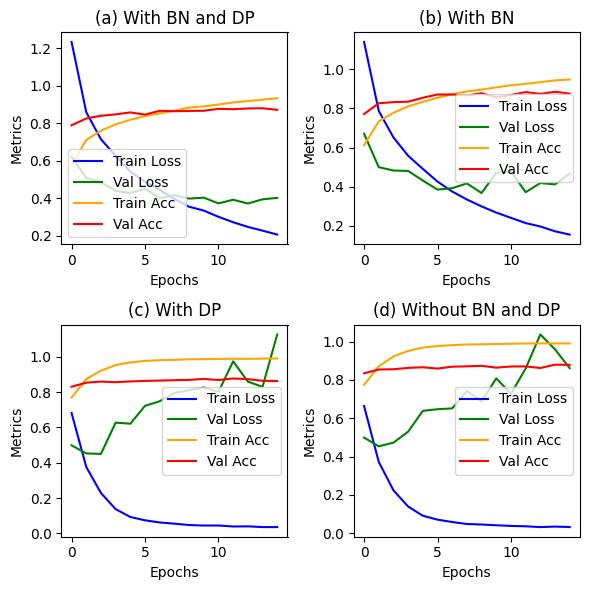

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes = axes.flatten()  # Flatten the array of axes to simplify the iteration

for idx, (config, history) in enumerate(histories.items()):
    # Convert train_acc and valid_acc from percentages to fractions
    train_acc = [acc / 100 for acc in history['train_acc']]
    valid_acc = [acc / 100 for acc in history['valid_acc']]
    train_loss = history['train_loss']
    valid_loss = history['valid_loss']

    # Use the flattened axes array
    ax = axes[idx]
    ax.plot(train_loss, 'b', label='Train Loss')
    ax.plot(valid_loss, 'g', label='Val Loss')
    ax.plot(train_acc, 'orange', label='Train Acc')
    ax.plot(valid_acc, 'r', label='Val Acc')
    ax.set_title(f'({chr(97 + idx)}) {config}')  # Updated indexing for subfigure labels
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Metrics')
    ax.legend()

plt.tight_layout()
plt.show()

#### Activation Function

In [12]:
import torchvision.models as models
import torch.nn as nn

def modify_vgg16(activation='relu'):
    # Load a new, untrained VGG16 model without pretrained weights
    model = models.vgg16(weights=VGG16_Weights.DEFAULT)

    # Define the activation function based on the input parameter
    if activation == 'relu':
        act_func = nn.ReLU(inplace=True)
    elif activation == 'leaky_relu':
        act_func = nn.LeakyReLU(0.01, inplace=True)
    elif activation == 'elu':
        act_func = nn.ELU(inplace=True)
    else:
        raise ValueError("Unsupported activation function: " + activation)

    # Modify the classifier to use the selected activation function without dropout
    classifier_layers = [
        nn.Linear(512 * 7 * 7, 4096),
        act_func,
        nn.Linear(4096, 4096),
        act_func,
        nn.Linear(4096, 10)  # Adjust the output layer for the number of classes in your dataset
    ]
    model.classifier = nn.Sequential(*classifier_layers)

    # Insert batch normalization after each Conv2d layer in the features module
    new_features = []
    for layer in model.features:
        new_features.append(layer)
        if isinstance(layer, nn.Conv2d):
            new_features.append(nn.BatchNorm2d(layer.out_channels))

    model.features = nn.Sequential(*new_features)

    return model


In [51]:
# Model configurations and training
acts = {
    'leaky_relu': modify_vgg16(activation='leaky_relu'),
    'elu': modify_vgg16(activation='elu')
}

histories = {}
for name, model in acts.items():
    print(f"Training {name}")
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    criterion = nn.CrossEntropyLoss()
    _,_,histories[name] = train(model, trainloader, valloader, criterion, optimizer, num_epochs=15, patience=5)

Training leaky_relu


100%|██████████| 2500/2500 [00:11<00:00, 222.05it/s]


Epoch 1, Train Loss: 1.1354, Train Acc: 60.90%, Validation Loss: 0.6389, Validation Acc: 78.53%


100%|██████████| 2500/2500 [00:10<00:00, 232.83it/s]


Epoch 2, Train Loss: 0.7983, Train Acc: 72.80%, Validation Loss: 0.5371, Validation Acc: 81.59%


100%|██████████| 2500/2500 [00:11<00:00, 226.43it/s]


Epoch 3, Train Loss: 0.6570, Train Acc: 77.95%, Validation Loss: 0.4564, Validation Acc: 84.68%


100%|██████████| 2500/2500 [00:11<00:00, 219.73it/s]


Epoch 4, Train Loss: 0.5586, Train Acc: 81.12%, Validation Loss: 0.4426, Validation Acc: 84.85%


100%|██████████| 2500/2500 [00:11<00:00, 224.67it/s]


Epoch 5, Train Loss: 0.4894, Train Acc: 83.47%, Validation Loss: 0.4351, Validation Acc: 85.33%


100%|██████████| 2500/2500 [00:10<00:00, 231.18it/s]


Epoch 6, Train Loss: 0.4247, Train Acc: 85.51%, Validation Loss: 0.4367, Validation Acc: 85.27%


100%|██████████| 2500/2500 [00:10<00:00, 230.85it/s]


Epoch 7, Train Loss: 0.3889, Train Acc: 86.89%, Validation Loss: 0.4450, Validation Acc: 85.67%


100%|██████████| 2500/2500 [00:10<00:00, 230.90it/s]


Epoch 8, Train Loss: 0.3390, Train Acc: 88.49%, Validation Loss: 0.4546, Validation Acc: 85.27%


100%|██████████| 2500/2500 [00:10<00:00, 232.27it/s]


Epoch 9, Train Loss: 0.2975, Train Acc: 89.80%, Validation Loss: 0.4297, Validation Acc: 86.09%


100%|██████████| 2500/2500 [00:11<00:00, 219.59it/s]


Epoch 10, Train Loss: 0.2684, Train Acc: 90.74%, Validation Loss: 0.4134, Validation Acc: 86.96%


100%|██████████| 2500/2500 [00:10<00:00, 227.54it/s]


Epoch 11, Train Loss: 0.2358, Train Acc: 91.98%, Validation Loss: 0.3719, Validation Acc: 88.48%


100%|██████████| 2500/2500 [00:10<00:00, 230.93it/s]


Epoch 12, Train Loss: 0.2175, Train Acc: 92.69%, Validation Loss: 0.3856, Validation Acc: 87.66%


100%|██████████| 2500/2500 [00:10<00:00, 233.43it/s]


Epoch 13, Train Loss: 0.1904, Train Acc: 93.60%, Validation Loss: 0.4259, Validation Acc: 88.36%


100%|██████████| 2500/2500 [00:11<00:00, 226.65it/s]


Epoch 14, Train Loss: 0.1718, Train Acc: 94.28%, Validation Loss: 0.4195, Validation Acc: 87.25%


100%|██████████| 2500/2500 [00:10<00:00, 228.20it/s]


Epoch 15, Train Loss: 0.1572, Train Acc: 94.63%, Validation Loss: 0.4383, Validation Acc: 87.85%
Training elu


100%|██████████| 2500/2500 [00:10<00:00, 232.89it/s]


Epoch 1, Train Loss: 1.1908, Train Acc: 58.83%, Validation Loss: 0.6459, Validation Acc: 77.32%


100%|██████████| 2500/2500 [00:10<00:00, 228.18it/s]


Epoch 2, Train Loss: 0.8196, Train Acc: 72.18%, Validation Loss: 0.5282, Validation Acc: 82.07%


100%|██████████| 2500/2500 [00:10<00:00, 233.29it/s]


Epoch 3, Train Loss: 0.6717, Train Acc: 77.11%, Validation Loss: 0.5333, Validation Acc: 81.86%


100%|██████████| 2500/2500 [00:10<00:00, 227.52it/s]


Epoch 4, Train Loss: 0.5690, Train Acc: 80.61%, Validation Loss: 0.4419, Validation Acc: 84.84%


100%|██████████| 2500/2500 [00:10<00:00, 234.18it/s]


Epoch 5, Train Loss: 0.5009, Train Acc: 82.95%, Validation Loss: 0.4240, Validation Acc: 85.75%


100%|██████████| 2500/2500 [00:10<00:00, 233.57it/s]


Epoch 6, Train Loss: 0.4425, Train Acc: 85.17%, Validation Loss: 0.4332, Validation Acc: 85.04%


100%|██████████| 2500/2500 [00:10<00:00, 232.07it/s]


Epoch 7, Train Loss: 0.3939, Train Acc: 86.73%, Validation Loss: 0.4109, Validation Acc: 85.86%


100%|██████████| 2500/2500 [00:10<00:00, 229.98it/s]


Epoch 8, Train Loss: 0.3422, Train Acc: 88.30%, Validation Loss: 0.4255, Validation Acc: 85.92%


100%|██████████| 2500/2500 [00:10<00:00, 230.45it/s]


Epoch 9, Train Loss: 0.3057, Train Acc: 89.61%, Validation Loss: 0.4292, Validation Acc: 86.62%


100%|██████████| 2500/2500 [00:10<00:00, 229.68it/s]


Epoch 10, Train Loss: 0.2718, Train Acc: 90.77%, Validation Loss: 0.4230, Validation Acc: 86.37%


100%|██████████| 2500/2500 [00:10<00:00, 232.46it/s]


Epoch 11, Train Loss: 0.2423, Train Acc: 91.71%, Validation Loss: 0.3958, Validation Acc: 87.41%


100%|██████████| 2500/2500 [00:10<00:00, 232.29it/s]


Epoch 12, Train Loss: 0.2155, Train Acc: 92.76%, Validation Loss: 0.4000, Validation Acc: 87.57%


100%|██████████| 2500/2500 [00:10<00:00, 229.31it/s]


Epoch 13, Train Loss: 0.1956, Train Acc: 93.39%, Validation Loss: 0.4263, Validation Acc: 87.27%


100%|██████████| 2500/2500 [00:10<00:00, 231.58it/s]


Epoch 14, Train Loss: 0.1754, Train Acc: 94.09%, Validation Loss: 0.4714, Validation Acc: 86.57%


100%|██████████| 2500/2500 [00:10<00:00, 228.07it/s]

Epoch 15, Train Loss: 0.1556, Train Acc: 94.81%, Validation Loss: 0.5108, Validation Acc: 86.85%


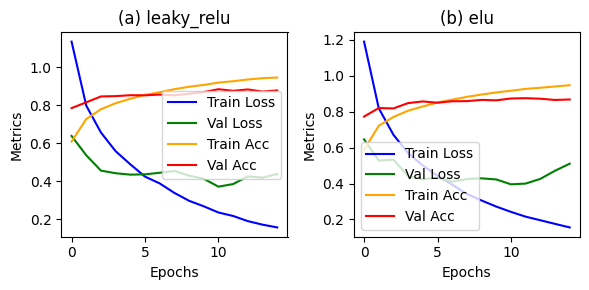

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes = axes.flatten()  # Flatten the array of axes to simplify the iteration

for idx, (config, history) in enumerate(histories.items()):
    # Convert train_acc and valid_acc from percentages to fractions
    train_acc = [acc / 100 for acc in history['train_acc']]
    valid_acc = [acc / 100 for acc in history['valid_acc']]
    train_loss = history['train_loss']
    valid_loss = history['valid_loss']

    # Use the flattened axes array
    ax = axes[idx]
    ax.plot(train_loss, 'b', label='Train Loss')
    ax.plot(valid_loss, 'g', label='Val Loss')
    ax.plot(train_acc, 'orange', label='Train Acc')
    ax.plot(valid_acc, 'r', label='Val Acc')
    ax.set_title(f'({chr(97 + idx)}) {config}')  # Updated indexing for subfigure labels
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Metrics')
    ax.legend()

plt.tight_layout()
plt.show()

Data Agumentation

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),  # 转换图片为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化
])
# Define transformations with data augmentation
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomVerticalFlip(),    # Randomly flip the images vertically
    transforms.RandomRotation(30),
    transforms.RandomCrop(32, padding=4),  # Randomly crop images with padding
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download the training and test datasets with transformations
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_augmented)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

# Splitting training set for training and validation
num_train = len(trainset)
num_val = int(0.2 * num_train)
num_train -= num_val

train_data, val_data = random_split(trainset, [num_train, num_val])

# DataLoader setup
trainloader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
valloader = DataLoader(val_data, batch_size=4, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [16]:
from torchvision.models import VGG16_Weights
model_with_activation = modify_vgg16(activation='leaky_relu')
# Set up the optimizer and criterion
optimizer = optim.Adam(model_with_activation.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

# Train the model
trained_model, best_accuracy, training_history = train(model_with_activation, trainloader, valloader, criterion, optimizer, num_epochs=15, patience=5)

100%|██████████| 2500/2500 [00:14<00:00, 172.40it/s]


Epoch 1, Train Loss: 1.6126, Train Acc: 42.16%, Validation Loss: 1.1188, Validation Acc: 60.02%


100%|██████████| 2500/2500 [00:14<00:00, 173.58it/s]


Epoch 2, Train Loss: 1.3647, Train Acc: 51.75%, Validation Loss: 1.0144, Validation Acc: 63.46%


100%|██████████| 2500/2500 [00:14<00:00, 174.57it/s]


Epoch 3, Train Loss: 1.2474, Train Acc: 56.44%, Validation Loss: 0.9435, Validation Acc: 66.90%


100%|██████████| 2500/2500 [00:14<00:00, 170.94it/s]


Epoch 4, Train Loss: 1.1585, Train Acc: 59.53%, Validation Loss: 0.8893, Validation Acc: 67.81%


100%|██████████| 2500/2500 [00:14<00:00, 173.12it/s]


Epoch 5, Train Loss: 1.0956, Train Acc: 61.55%, Validation Loss: 0.8369, Validation Acc: 70.95%


100%|██████████| 2500/2500 [00:14<00:00, 173.56it/s]


Epoch 6, Train Loss: 1.0463, Train Acc: 63.34%, Validation Loss: 0.8375, Validation Acc: 71.29%


100%|██████████| 2500/2500 [00:14<00:00, 173.10it/s]


Epoch 7, Train Loss: 1.0010, Train Acc: 65.19%, Validation Loss: 0.7809, Validation Acc: 72.74%


100%|██████████| 2500/2500 [00:14<00:00, 174.03it/s]


Epoch 8, Train Loss: 0.9596, Train Acc: 66.62%, Validation Loss: 0.8226, Validation Acc: 72.16%


100%|██████████| 2500/2500 [00:14<00:00, 170.23it/s]


Epoch 9, Train Loss: 0.9288, Train Acc: 67.70%, Validation Loss: 0.7708, Validation Acc: 73.09%


100%|██████████| 2500/2500 [00:14<00:00, 173.88it/s]


Epoch 10, Train Loss: 0.9078, Train Acc: 68.43%, Validation Loss: 0.7422, Validation Acc: 74.33%


100%|██████████| 2500/2500 [00:14<00:00, 173.43it/s]


Epoch 11, Train Loss: 0.8775, Train Acc: 69.40%, Validation Loss: 0.7216, Validation Acc: 74.66%


100%|██████████| 2500/2500 [00:14<00:00, 175.73it/s]


Epoch 12, Train Loss: 0.8534, Train Acc: 70.03%, Validation Loss: 0.6827, Validation Acc: 76.07%


100%|██████████| 2500/2500 [00:14<00:00, 173.25it/s]


Epoch 13, Train Loss: 0.8379, Train Acc: 70.89%, Validation Loss: 0.6978, Validation Acc: 75.99%


100%|██████████| 2500/2500 [00:14<00:00, 174.75it/s]


Epoch 14, Train Loss: 0.8178, Train Acc: 71.53%, Validation Loss: 0.6980, Validation Acc: 75.89%


100%|██████████| 2500/2500 [00:14<00:00, 173.87it/s]

Epoch 15, Train Loss: 0.7986, Train Acc: 72.19%, Validation Loss: 0.6524, Validation Acc: 77.50%


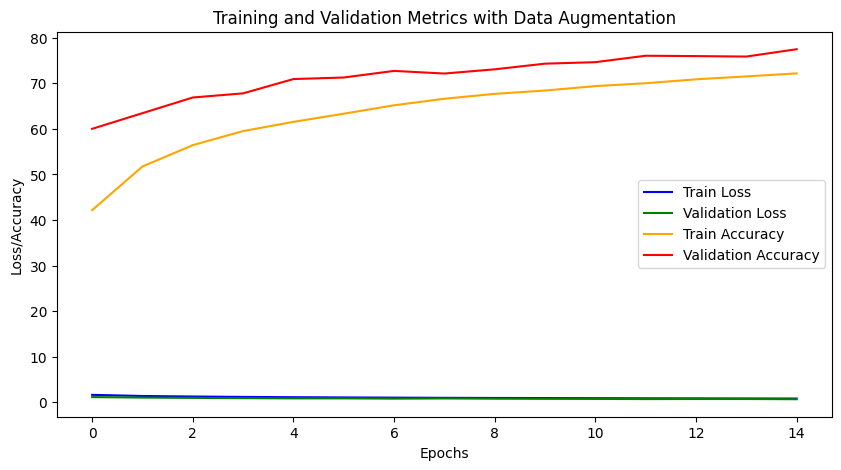

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(training_history['train_loss'], label='Train Loss', color='blue')
plt.plot(training_history['valid_loss'], label='Validation Loss', color='green')
plt.plot(training_history['train_acc'], label='Train Accuracy', color='orange')
plt.plot(training_history['valid_acc'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Metrics with Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

## Test and Result

In [10]:
import torchvision.models as models
import torch.nn as nn

def final_vgg16():
    # Load a new, untrained VGG16 model without pretrained weights
    model = models.vgg16(weights=VGG16_Weights.DEFAULT)

    act_func = nn.LeakyReLU(0.01, inplace=True)


    # Modify the classifier to use the selected activation function without dropout
    classifier_layers = [
        nn.Linear(512 * 7 * 7, 4096),
        act_func,
        nn.Linear(4096, 4096),
        act_func,
        nn.Linear(4096, 10)  # Adjust the output layer for the number of classes in your dataset
    ]
    model.classifier = nn.Sequential(*classifier_layers)

    # Insert batch normalization after each Conv2d layer in the features module
    new_features = []
    for layer in model.features:
        new_features.append(layer)
        if isinstance(layer, nn.Conv2d):
            new_features.append(nn.BatchNorm2d(layer.out_channels))

    model.features = nn.Sequential(*new_features)

    return model


In [13]:
from torchvision.models import VGG16_Weights
final_model = final_vgg16()
# Set up the optimizer and criterion
optimizer = optim.Adam(final_model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

# Train the model
trained_model, best_accuracy, training_history = train(final_model, trainloader, valloader, criterion, optimizer, num_epochs=50, patience=10)

100%|██████████| 2500/2500 [00:11<00:00, 223.92it/s]


Epoch 1, Train Loss: 1.1392, Train Acc: 60.95%, Validation Loss: 0.6412, Validation Acc: 78.08%


100%|██████████| 2500/2500 [00:10<00:00, 237.56it/s]


Epoch 2, Train Loss: 0.7911, Train Acc: 73.50%, Validation Loss: 0.5435, Validation Acc: 81.69%


100%|██████████| 2500/2500 [00:10<00:00, 230.68it/s]


Epoch 3, Train Loss: 0.6507, Train Acc: 77.97%, Validation Loss: 0.5193, Validation Acc: 82.60%


100%|██████████| 2500/2500 [00:11<00:00, 225.09it/s]


Epoch 4, Train Loss: 0.5643, Train Acc: 80.97%, Validation Loss: 0.4997, Validation Acc: 83.19%


100%|██████████| 2500/2500 [00:10<00:00, 236.94it/s]


Epoch 5, Train Loss: 0.4910, Train Acc: 83.38%, Validation Loss: 0.4121, Validation Acc: 86.04%


100%|██████████| 2500/2500 [00:10<00:00, 230.16it/s]


Epoch 6, Train Loss: 0.4311, Train Acc: 85.37%, Validation Loss: 0.4048, Validation Acc: 86.70%


100%|██████████| 2500/2500 [00:10<00:00, 238.51it/s]


Epoch 7, Train Loss: 0.3790, Train Acc: 87.14%, Validation Loss: 0.4451, Validation Acc: 85.40%


100%|██████████| 2500/2500 [00:10<00:00, 228.15it/s]


Epoch 8, Train Loss: 0.3401, Train Acc: 88.50%, Validation Loss: 0.4170, Validation Acc: 86.43%


100%|██████████| 2500/2500 [00:10<00:00, 236.92it/s]


Epoch 9, Train Loss: 0.2971, Train Acc: 89.92%, Validation Loss: 0.4020, Validation Acc: 87.49%


100%|██████████| 2500/2500 [00:10<00:00, 239.26it/s]


Epoch 10, Train Loss: 0.2692, Train Acc: 90.96%, Validation Loss: 0.3968, Validation Acc: 87.72%


100%|██████████| 2500/2500 [00:10<00:00, 238.66it/s]


Epoch 11, Train Loss: 0.2374, Train Acc: 92.12%, Validation Loss: 0.4464, Validation Acc: 86.67%


100%|██████████| 2500/2500 [00:10<00:00, 238.64it/s]


Epoch 12, Train Loss: 0.2161, Train Acc: 92.76%, Validation Loss: 0.4379, Validation Acc: 86.88%


100%|██████████| 2500/2500 [00:10<00:00, 238.76it/s]


Epoch 13, Train Loss: 0.1900, Train Acc: 93.57%, Validation Loss: 0.4429, Validation Acc: 86.95%


100%|██████████| 2500/2500 [00:10<00:00, 237.33it/s]


Epoch 14, Train Loss: 0.1730, Train Acc: 94.13%, Validation Loss: 0.4132, Validation Acc: 87.27%


100%|██████████| 2500/2500 [00:10<00:00, 244.37it/s]


Epoch 15, Train Loss: 0.1543, Train Acc: 94.97%, Validation Loss: 0.4162, Validation Acc: 88.24%


100%|██████████| 2500/2500 [00:10<00:00, 234.50it/s]


Epoch 16, Train Loss: 0.1413, Train Acc: 95.39%, Validation Loss: 0.4021, Validation Acc: 88.52%


100%|██████████| 2500/2500 [00:10<00:00, 235.47it/s]


Epoch 17, Train Loss: 0.1275, Train Acc: 95.72%, Validation Loss: 0.4626, Validation Acc: 87.96%


100%|██████████| 2500/2500 [00:10<00:00, 233.06it/s]


Epoch 18, Train Loss: 0.1191, Train Acc: 95.97%, Validation Loss: 0.4162, Validation Acc: 88.29%


100%|██████████| 2500/2500 [00:10<00:00, 232.38it/s]


Epoch 19, Train Loss: 0.1057, Train Acc: 96.36%, Validation Loss: 0.4614, Validation Acc: 87.80%


100%|██████████| 2500/2500 [00:10<00:00, 235.87it/s]


Epoch 20, Train Loss: 0.1000, Train Acc: 96.75%, Validation Loss: 0.4851, Validation Acc: 87.27%


100%|██████████| 2500/2500 [00:10<00:00, 240.14it/s]


Epoch 21, Train Loss: 0.0909, Train Acc: 97.07%, Validation Loss: 0.4748, Validation Acc: 87.66%


100%|██████████| 2500/2500 [00:10<00:00, 240.08it/s]


Epoch 22, Train Loss: 0.0878, Train Acc: 97.17%, Validation Loss: 0.5309, Validation Acc: 87.83%


100%|██████████| 2500/2500 [00:10<00:00, 241.35it/s]


Epoch 23, Train Loss: 0.0786, Train Acc: 97.47%, Validation Loss: 0.4702, Validation Acc: 88.21%


100%|██████████| 2500/2500 [00:10<00:00, 234.47it/s]


Epoch 24, Train Loss: 0.0736, Train Acc: 97.54%, Validation Loss: 0.4922, Validation Acc: 87.99%


100%|██████████| 2500/2500 [00:10<00:00, 231.50it/s]


Epoch 25, Train Loss: 0.0718, Train Acc: 97.75%, Validation Loss: 0.4357, Validation Acc: 88.38%


100%|██████████| 2500/2500 [00:10<00:00, 234.98it/s]

Epoch 26, Train Loss: 0.0688, Train Acc: 97.74%, Validation Loss: 0.5220, Validation Acc: 87.96%
Early stopping!


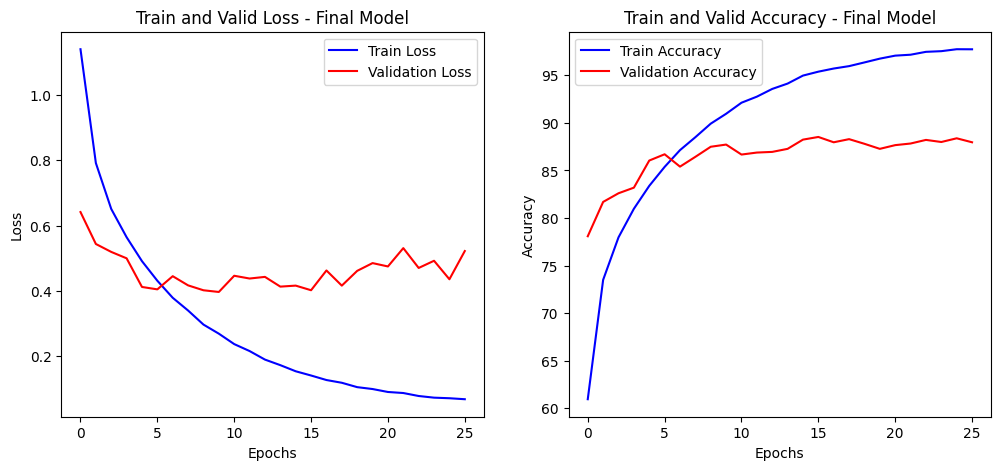

In [16]:
plot_training_history(training_history,"Final Model")

In [17]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np

def evaluate_model(model, test_loader, classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())  # Collect all predictions
            all_labels.extend(labels.cpu().numpy())  # Collect all true labels

    # Compute the confusion matrix and normalize it
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

    print(f'Accuracy on the test set: {100 * correct / total:.2f}%')
    return cm_normalized

# Assuming you have defined `classes` which is the list of class names in the CIFAR-10 dataset
label_alpha = classes  # Labels for the axes in the heatmap

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=True, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()


In [20]:
normalized_conf_matrix = evaluate_model(trained_model, testloader, classes)

Accuracy on the test set: 87.77%


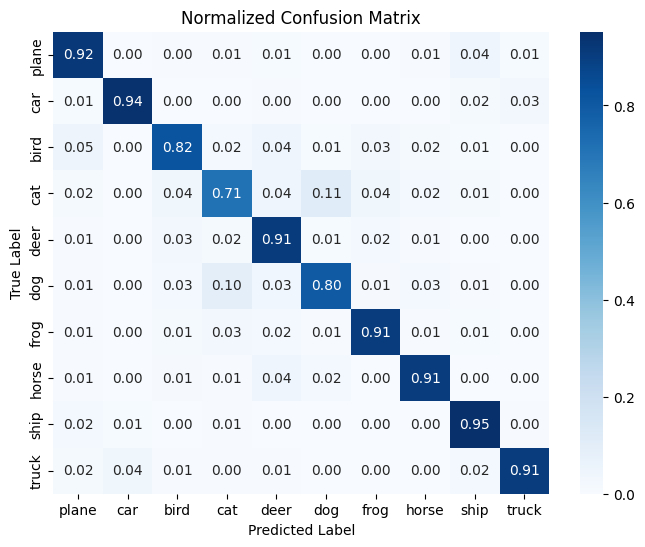

In [26]:
plot_confusion_matrix(normalized_conf_matrix, label_alpha)

In [22]:
torch.save(trained_model.state_dict(), 'final_model.pth')